<h1><center>NER - Resume Extractor</center></h1>
<h1><center>By: Team ZeRoS</center></h1>

<h2><center>Team Members:</center></h2>
<h3><center>Reeka Hazarika</center></h3>
<h3><center>Swapnil Vishwakarma</center></h3>
<h3><center>Zyad Al-Azazi</center></h3>

## Problem Description:
When companies recruit for any position, they usually end up receiving thousands, if not millions, of resumes. Such a uge number of resumes makes the task of going over all these resumes an extremely difficult and tedious job for HR employees. This made a lot of companies opt for systems that take the necessary information from the candidate after they fill an application with all the required fields. The solution worked greatly for employers; nevertheless, candidates have always found it very illogical to spend tens of hours sharpening their CVs and cover letters only to find out that they must spend another hour or so re-entering all the information they have on their CVs in the designated fields.

## Business Understanding:
It is often observed by HR that the manual process of evaluation of Resumes in bulk which are populated with excess information often becomes tedious and hectic. Therefore, we could automate this process by reading several formats of files (CV). Then using some basic techniques of Natural Language Processing like word parsing, chunking, regex parser and/or Named Entity Recognition to easily capture information like name, email id, address, educational qualification, experience in seconds from a large number of documents.

## File Ingestion and Schema Validation

In [1]:
%%writefile testutility.py
import logging
import os
import subprocess
import yaml
import pandas as pd
import datetime 
import gc
import re

def read_yml_file(file_path):
    with open(file_path, 'r') as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            logging.error(exc)

def replacer(string, char):
    pattern = char + '{2,}'
    string = re.sub(pattern, char, string)
    return string

def col_validate(df, col_config):
  cols = df.columns
  cols = cols.str.strip()
  cols.str.replace("_", "")
  cols = list(map(lambda x: replacer(x, ' '), list(cols)))
  expected_col = list(map(lambda x: x.lower(),  col_config['columns']))
  cols.sort()
  expected_col.sort()
  if len(cols) == len(expected_col) and cols == expected_col:
    print("Column name and Column length Validation Passed!!")
    return 1
  else:
    print("Column name and Column length Validation Failed..")
    mismatched_columns_file = list(set(cols).difference(expected_col))
    print("Following File columns are not in the YAML file", mismatched_columns_file)
    missing_YAML_file = list(set(expected_col).difference(cols))
    print("Following YAML columns are not in the file uploaded", missing_YAML_file)
    logging.info(f'df columns: {cols}')
    logging.info(f'expected columns: {expected_col}')
    return 0

# Function to get the size of dataset
def humanbytes(B):
  'Return the given bytes as a human friendly KB, MB, GB, or TB string'
  B = float(B)
  KB = float(1024)
  MB = float(KB ** 2) # 1,048,576
  GB = float(KB ** 3) # 1,073,741,824
  TB = float(KB ** 4) # 1,099,511,627,776

  if B < KB:
    return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
  elif KB <= B < MB:
    return '{0:.2f} KB'.format(B/KB)
  elif MB <= B < GB:
    return '{0:.2f} MB'.format(B/MB)
  elif GB <= B < TB:
    return '{0:.2f} GB'.format(B/GB)
  elif TB <= B:
    return '{0:.2f} TB'.format(B/TB)

Writing testutility.py


# Writing YAML File

In [2]:
%%writefile file.yaml
columns: 
  - annotation
  - content
dataset_name: resumes
dtypes: 
  annotation: list
  content: str
file_name: Resume
file_type: json
skip_leading_rows: 1
table_name: resumes

Writing file.yaml


# Reading the Configuration File

In [3]:
# Read config file
import testutility as util
col_config = util.read_yml_file("file.yaml")

In [4]:
#inspecting data of config file
col_config

{'columns': ['annotation', 'content'],
 'dataset_name': 'resumes',
 'dtypes': {'annotation': 'list', 'content': 'str'},
 'file_name': 'Resume',
 'file_type': 'json',
 'skip_leading_rows': 1,
 'table_name': 'resumes'}

In [5]:
# Read the file using yaml config file
file_type = col_config['file_type']
source_file = col_config['file_name'] + f'.{file_type}'
source_file

'Resume.json'

In [6]:
import pandas as pd

df = pd.read_json('Resume.json', lines=True)
df.to_csv('dataframe.csv', index = None)
df.head()

,content,annotation
0,Govardhana K\nSenior Software Engineer\n\nBeng...,"[{'label': ['Companies worked at'], 'points': ..."
1,"Harini Komaravelli\nTest Analyst at Oracle, Hy...","[{'label': ['Companies worked at'], 'points': ..."
2,Hartej Kathuria\nData Analyst Intern - Oracle ...,"[{'label': ['Skills'], 'points': [{'start': 22..."
3,Ijas Nizamuddin\nAssociate Consultant - State ...,"[{'label': ['Skills'], 'points': [{'start': 46..."
4,"Imgeeyaul Ansari\njava developer\n\nPune, Maha...","[{'label': ['Skills'], 'points': [{'start': 18..."


In [ ]:
# Getting the size of the dataset
size = df.memory_usage(deep=True).sum()
file_size = util.humanbytes(size)
print(file_size)

1.41 MB


In [ ]:
# Checking the shape of dataframe
df.shape

(200, 2)

In [ ]:
# Checking no. of NA Values
df.isnull().sum()

content       0
annotation    0
dtype: int64

In [ ]:
df['annotation'][0]

[{'label': ['Companies worked at'],
  'points': [{'end': 1754, 'start': 1749, 'text': 'Oracle'}]},
 {'label': ['Companies worked at'],
  'points': [{'end': 1701, 'start': 1696, 'text': 'Oracle'}]},
 {'label': ['Companies worked at'],
  'points': [{'end': 1422, 'start': 1417, 'text': 'Oracle'}]},
 {'label': ['Skills'],
  'points': [{'end': 1792,
    'start': 1356,
    'text': 'Languages: Core Java, Go Lang, Data Structures & Algorithms, Oracle\nPL-SQL programming, Sales Force with APEX.\nTools: RADTool, Jdeveloper, NetBeans, Eclipse, SQL developer,\nPL/SQL Developer, WinSCP, Putty\nWeb Technologies: JavaScript, XML, HTML, Webservice\n\nOperating Systems: Linux, Windows\nVersion control system SVN & Git-Hub\nDatabases: Oracle\nMiddleware: Web logic, OC4J\nProduct FLEXCUBE: Oracle FLEXCUBE Versions 10.x, 11.x and 12.x'}]},
 {'label': ['Companies worked at'],
  'points': [{'end': 1214, 'start': 1209, 'text': 'Oracle'}]},
 {'label': ['Skills'],
  'points': [{'end': 1247,
    'start': 1136,


In [ ]:
df['content'][0]

'Govardhana K\nSenior Software Engineer\n\nBengaluru, Karnataka, Karnataka - Email me on Indeed: indeed.com/r/Govardhana-K/\nb2de315d95905b68\n\nTotal IT experience 5 Years 6 Months\nCloud Lending Solutions INC 4 Month • Salesforce Developer\nOracle 5 Years 2 Month • Core Java Developer\nLanguages Core Java, Go Lang\nOracle PL-SQL programming,\nSales Force Developer with APEX.\n\nDesignations & Promotions\n\nWilling to relocate: Anywhere\n\nWORK EXPERIENCE\n\nSenior Software Engineer\n\nCloud Lending Solutions -  Bangalore, Karnataka -\n\nJanuary 2018 to Present\n\nPresent\n\nSenior Consultant\n\nOracle -  Bangalore, Karnataka -\n\nNovember 2016 to December 2017\n\nStaff Consultant\n\nOracle -  Bangalore, Karnataka -\n\nJanuary 2014 to October 2016\n\nAssociate Consultant\n\nOracle -  Bangalore, Karnataka -\n\nNovember 2012 to December 2013\n\nEDUCATION\n\nB.E in Computer Science Engineering\n\nAdithya Institute of Technology -  Tamil Nadu\n\nSeptember 2008 to June 2012\n\nhttps://www.

In [ ]:
# Validating Input File
if util.col_validate(df, col_config) == 0:
    print("Validation Failed!!")
else:
    print("Column Validation Passed..")

Column name and Column length Validation Passed!!
Column Validation Passed..


# Cleaning the Data

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
!pip install num2words
from num2words import num2words
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Text cleaning function
def clean_text(resume):
    
    resume = resume.lower()  #lower-casing all the characters
    
    resume = expand_contractions(resume)  #expanding any contractions
    
    # removing all the unnecessary characters
    resume = re.sub("\n", ' ', resume)
    resume = re.sub(r'[,•()➢❑]', ' ', resume)
    resume = re.sub(r'\s\s+|\s-\s|\.\s', ' ', resume)
    
    # tokenizing words using spaces to avoid losing important information such as the emails
    tokenized_words = resume.split(" ")
    
    #length = len(tokenized_words)
    #for i in range(length):
     #   if tokenized_words[i].isdigit():
      #      tokenized_words[i] = num2words(tokenized_words[i])
    
    
    # removing stop words
    sw = set(stopwords.words('english'))
    
    tokens_without_sw = []
    
    for w in tokenized_words:
        if w not in sw:
            tokens_without_sw.append(w)
    
    # lemmatizing words
    lm = WordNetLemmatizer() 
    tokens_without_sw = [lm.lemmatize(word) for word in tokens_without_sw if not word in set(sw)]
    
    # joining all words to get one full string
    final_resume = " ".join(tokens_without_sw)
    
    return final_resume

In [ ]:
resume_content = df['content']

resume_content

0      Govardhana K\nSenior Software Engineer\n\nBeng...
1      Harini Komaravelli\nTest Analyst at Oracle, Hy...
2      Hartej Kathuria\nData Analyst Intern - Oracle ...
3      Ijas Nizamuddin\nAssociate Consultant - State ...
4      Imgeeyaul Ansari\njava developer\n\nPune, Maha...
                             ...                        
195    Mansi Thanki\nStudent\n\nJamnagar, Gujarat - E...
196    Anil Kumar\nMicrosoft Azure (Basic Management)...
197    Siddharth Choudhary\nMicrosoft Office Suite - ...
198    Valarmathi Dhandapani\nInvestment Banking Oper...
199    Pradeep Kumar\nSecurity Analyst in Infosys - C...
Name: content, Length: 200, dtype: object

In [ ]:
dict = {'content':[]}
clean_resumes = pd.DataFrame(dict)

for resume in resume_content:
    clean_resumes.loc[len(clean_resumes.index)] = clean_text(resume) 
    
    
clean_resumes

,content
0,govardhana k senior software engineer bengalur...
1,harini komaravelli test analyst oracle hyderab...
2,hartej kathuria data analyst intern oracle ret...
3,ijas nizamuddin associate consultant state str...
4,imgeeyaul ansari java developer pune maharasht...
...,...
195,mansi thanki student jamnagar gujarat email in...
196,anil kumar microsoft azure basic management de...
197,siddharth choudhary microsoft office suite exp...
198,valarmathi dhandapani investment banking opera...


In [ ]:
# A sample of the clean resume data

clean_resumes['content'][0]

'govardhana k senior software engineer bengaluru karnataka karnataka email indeed: indeed.com/r/govardhana-k/ b2de315d95905b68 total experience 5 year 6 month cloud lending solution inc 4 month salesforce developer oracle 5 year 2 month core java developer language core java go lang oracle pl-sql programming sale force developer apex  designation & promotion willing relocate: anywhere work experience senior software engineer cloud lending solution  bangalore karnataka  january 2018 present present senior consultant oracle  bangalore karnataka  november 2016 december 2017 staff consultant oracle  bangalore karnataka  january 2014 october 2016 associate consultant oracle  bangalore karnataka  november 2012 december 2013 education b.e computer science engineering adithya institute technology  tamil nadu september 2008 june 2012 https://www.indeed.com/r/govardhana-k/b2de315d95905b68?isid=rex-download&ikw=download-top&co=in https://www.indeed.com/r/govardhana-k/b2de315d95905b68?isid=rex-dow

In [ ]:
# We can see that this resume has an issue of no spaces between words, which makes it hardly ever readable.
# Thus, deleting this row is the best solution in this case.

clean_resumes['content'][154]

"jacob philip kottayam kerala email indeed: indeed.com/r/jacob-philip/db00d831146c9228 strategicsales experienceinsales skills.currently success  work experience sale marketing specialist assistantbusinessdevelopmentmanager  dubai ae  february 2017 october 2017 uae -builtstrong clientrelationshipsandprovidedhighvalue-addingservices resultingina15% company marketshareincrease developstools practicesacrosstheorganization negotiatingcontractsandpackages negotiatingthetermsofanagreementwithaviewto closingsale expense andnew businessdata workedcloselywithpartners throughconductingqualityassurancetests.actasthepointofcontactandcommunicate projectstatustoallparticipantsinourteam ordinator marketingco  january 2015 june 2016 bhimajewelers kerala india systemreportforms plannedandexecutedeventsandmarketingprograms producingfivetimestargetnumberof qualifiedleads implement marketing advertising campaign assembling analyzing sale forecastsandincreasedperformanceby52percent preparesmarketingreports

In [ ]:
clean_resumes.drop([154], axis = 0, inplace = True)

# Featurization Using Tf-Idf

In [ ]:
### We use the Tf-Idf vectorizer to gain insights about the probabilities of all the possible words and collocations
### we can find in these reusmes.
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(ngram_range = (1, 3))
tf_idf = vect.fit_transform(clean_resumes['content'])
terms = vect.get_feature_names()
#print(terms)
print(tf_idf)

  (0, 459)	0.04099920254609702
  (0, 360)	0.04099920254609702
  (0, 178)	0.03803341461440172
  (0, 116439)	0.04099920254609702
  (0, 44280)	0.04099920254609702
  (0, 74526)	0.04099920254609702
  (0, 44277)	0.04099920254609702
  (0, 82309)	0.04099920254609702
  (0, 72772)	0.04099920254609702
  (0, 62767)	0.04099920254609702
  (0, 117792)	0.04099920254609702
  (0, 68239)	0.04099920254609702
  (0, 74606)	0.04099920254609702
  (0, 30160)	0.04099920254609702
  (0, 50198)	0.04099920254609702
  (0, 46566)	0.04099920254609702
  (0, 104470)	0.04099920254609702
  (0, 105218)	0.04099920254609702
  (0, 26164)	0.04099920254609702
  (0, 116449)	0.035929154589110036
  (0, 118658)	0.03803341461440172
  (0, 62247)	0.03803341461440172
  (0, 105334)	0.035929154589110036
  (0, 73924)	0.03085910663212305
  (0, 117964)	0.04099920254609702
  :	:
  (198, 119196)	0.006696917115165575
  (198, 52504)	0.020090751345496725
  (198, 52688)	0.006696917115165575
  (198, 37486)	0.006696917115165575
  (198, 107278)	0.02

# POS Tagging

In [ ]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 1.2MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp37-none-any.whl size=98051305 sha256=f9e7b81b481a2d7d09ae0ee1b1b2280f139eefc4e94daa3fc2735ad41560fd6c
  Stored in directory: /tmp/pip-ephem-wheel-cache-g0d1o4uq/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
import spacy
import en_core_web_md

# load en_core_web_md of English for vocabluary, syntax & entities
nlp = en_core_web_md.load()

#  "nlp" Object used to create documents with linguistic annotations.
tags = nlp(clean_resumes['content'][100])

for word in tags:
    print(word.text, word.pos_)

puneet PROPN
bhandari PROPN
sap PROPN
sd PROPN
lead PROPN
microsoft PROPN
pune PROPN
maharashtra PROPN
email NOUN
indeed ADV
: PUNCT
indeed.com/r/puneet-bhandari/c9002fa44d6760bd PROPN
willing ADJ
relocate VERB
: PUNCT
anywhere ADV
work VERB
experience NOUN
sap PROPN
sd PROPN
lead NOUN
microsoft PROPN
  SPACE
august PROPN
2010 NUM
present ADJ
team NOUN
size NOUN
: PUNCT
8 NUM
duration NOUN
: PUNCT
seven NUM
month NOUN
scope NOUN
: PUNCT
* PUNCT
enhancement PROPN
mexico PROPN
invoicing NOUN
process NOUN
per ADP
current ADJ
regulation NOUN
* PUNCT
requirement NOUN
gathering VERB
third ADJ
party NOUN
client NOUN
new ADJ
process NOUN
* PUNCT
responsible ADJ
implementing VERB
change NOUN
system NOUN
area NOUN
exposure NOUN
: PUNCT
* PUNCT
understand VERB
as SCONJ
- PUNCT
is AUX
process NOUN
develop VERB
to- PROPN
design PROPN
document PROPN
meet PROPN
business PROPN
government NOUN
requirement NOUN
* PUNCT
requirement NOUN
gathering NOUN
sd NOUN
process NOUN
client NOUN
* PUNCT
developed VE

# Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
len(clean_resumes)

199

In [ ]:
# Description of the whole dataset.
clean_resumes.describe()

,content
count,199
unique,198
top,sameer kujur orrisha email indeed: indeed.com/...
freq,2


In [ ]:
# We can see that there is one row that is duplicated. We need to remove the second occurrence of the record.

clean_resumes = clean_resumes.drop_duplicates()
clean_resumes

,content
0,govardhana k senior software engineer bengalur...
1,harini komaravelli test analyst oracle hyderab...
2,hartej kathuria data analyst intern oracle ret...
3,ijas nizamuddin associate consultant state str...
4,imgeeyaul ansari java developer pune maharasht...
...,...
195,mansi thanki student jamnagar gujarat email in...
196,anil kumar microsoft azure basic management de...
197,siddharth choudhary microsoft office suite exp...
198,valarmathi dhandapani investment banking opera...


In [ ]:
def get_avg_word_len(x):
  words = x.split()
  word_len = 0
  for word in words:
    word_len += len(word)
  return word_len / len(words)

In [ ]:
clean_resumes['avg_word_len'] = clean_resumes['content'].apply(lambda x: get_avg_word_len(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
clean_resumes['content_len'] = clean_resumes['content'].apply(lambda x: len(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
clean_resumes['word_count'] = clean_resumes['content'].apply(lambda x: len(x.split()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
clean_resumes.head()

,content,avg_word_len,content_len,word_count
0,govardhana k senior software engineer bengalur...,7.768421,1676,190
1,harini komaravelli test analyst oracle hyderab...,7.246679,4372,527
2,hartej kathuria data analyst intern oracle ret...,6.760870,2144,276
3,ijas nizamuddin associate consultant state str...,7.263043,3812,460
4,imgeeyaul ansari java developer pune maharasht...,6.456790,1826,243


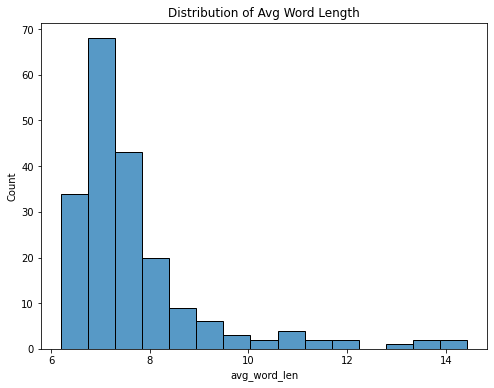

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(clean_resumes['avg_word_len'], bins=15);
plt.title('Distribution of Avg Word Length')
plt.show()

Most of the Resumes have average word length of 7

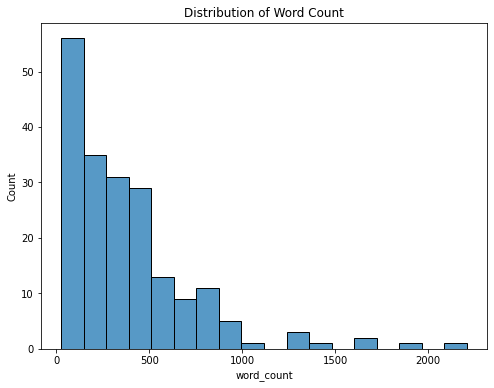

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(clean_resumes['word_count']);
plt.title('Distribution of Word Count')
plt.show()

Most of the Resumes are having less than 500 words

## Distribution of Unigram, Bigram & Trigram

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

### Unigram

In [ ]:
def get_top_n_words(x, n):
  vec = CountVectorizer().fit(x)
  bow = vec.transform(x)
  sum_words = bow.sum(axis = 0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
  return words_freq[:n]

In [ ]:
words = get_top_n_words(clean_resumes['content'], 50)

In [ ]:
words

[('indeed', 672),
 ('year', 649),
 ('management', 629),
 ('project', 609),
 ('com', 564),
 ('download', 557),
 ('team', 542),
 ('experience', 521),
 ('application', 481),
 ('system', 452),
 ('skill', 439),
 ('testing', 421),
 ('microsoft', 420),
 ('work', 419),
 ('client', 401),
 ('test', 393),
 ('data', 385),
 ('service', 366),
 ('using', 366),
 ('in', 339),
 ('support', 321),
 ('https', 313),
 ('www', 313),
 ('co', 310),
 ('customer', 309),
 ('oracle', 303),
 ('tool', 300),
 ('business', 297),
 ('server', 296),
 ('technology', 291),
 ('process', 290),
 ('technical', 289),
 ('top', 287),
 ('software', 275),
 ('isid', 275),
 ('rex', 275),
 ('ikw', 275),
 ('report', 275),
 ('issue', 261),
 ('sap', 258),
 ('development', 255),
 ('engineer', 251),
 ('sql', 245),
 ('email', 233),
 ('information', 233),
 ('infosys', 230),
 ('knowledge', 227),
 ('worked', 223),
 ('requirement', 222),
 ('education', 219)]

In [ ]:
df1 = pd.DataFrame(words, columns = ['Unigram', 'Frequency'])
df1

,Unigram,Frequency
0,indeed,672
1,year,649
2,management,629
3,project,609
4,com,564
5,download,557
6,team,542
7,experience,521
8,application,481
9,system,452


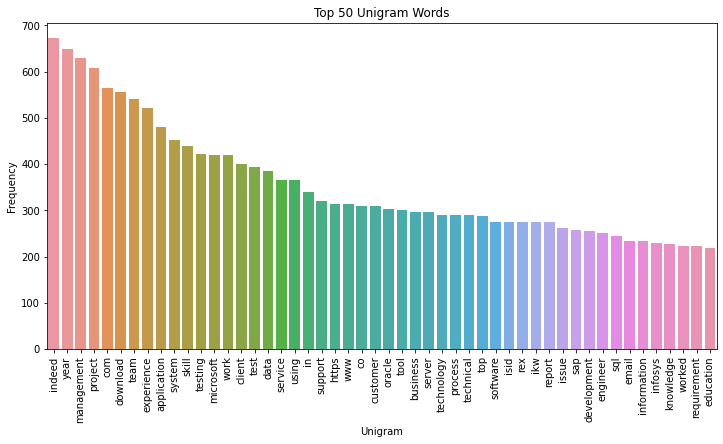

In [ ]:
plt.figure(figsize = (12, 6))
g = sns.barplot(data = df1, x = 'Unigram', y = 'Frequency');
g.set_xticklabels(df1['Unigram'], rotation=90)
plt.title('Top 50 Unigram Words')
plt.show()

### Bigram

In [ ]:
def get_top_n_words(x, n):
  vec = CountVectorizer(ngram_range=(2, 2)).fit(x)
  bow = vec.transform(x)
  sum_words = bow.sum(axis = 0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
  return words_freq[:n]

In [ ]:
words = get_top_n_words(clean_resumes['content'], 50)

In [ ]:
words

[('indeed com', 473),
 ('https www', 297),
 ('www indeed', 275),
 ('isid rex', 275),
 ('rex download', 275),
 ('download ikw', 275),
 ('ikw download', 275),
 ('download top', 275),
 ('top co', 275),
 ('co in', 275),
 ('work experience', 210),
 ('email indeed', 198),
 ('indeed indeed', 198),
 ('le year', 190),
 ('additional information', 139),
 ('bengaluru karnataka', 107),
 ('willing relocate', 86),
 ('infosys limited', 86),
 ('tamil nadu', 83),
 ('in https', 80),
 ('test case', 78),
 ('year additional', 69),
 ('system engineer', 66),
 ('sql server', 65),
 ('engineer infosys', 60),
 ('hyderabad telangana', 57),
 ('pune maharashtra', 56),
 ('team member', 55),
 ('karnataka email', 53),
 ('year experience', 53),
 ('pvt ltd', 53),
 ('operating system', 52),
 ('relocate to', 48),
 ('software engineer', 47),
 ('asp net', 47),
 ('project management', 42),
 ('microsoft office', 42),
 ('computer science', 41),
 ('information technical', 40),
 ('problem solving', 39),
 ('relocate anywhere', 37)

In [ ]:
df2 = pd.DataFrame(words, columns = ['Bigram', 'Frequency'])
df2

,Bigram,Frequency
0,indeed com,473
1,https www,297
2,www indeed,275
3,isid rex,275
4,rex download,275
5,download ikw,275
6,ikw download,275
7,download top,275
8,top co,275
9,co in,275


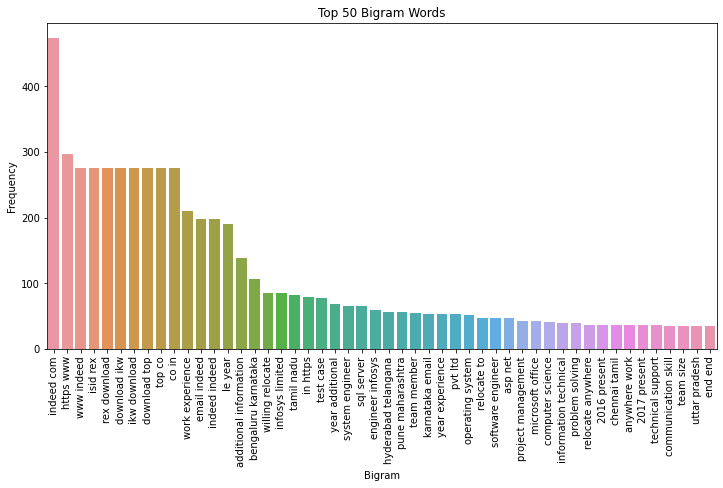

In [ ]:
plt.figure(figsize = (12, 6))
g = sns.barplot(data = df2, x = 'Bigram', y = 'Frequency');
g.set_xticklabels(df2['Bigram'], rotation=90)
plt.title('Top 50 Bigram Words')
plt.show()

### Trigram

In [ ]:
def get_top_n_words(x, n):
  vec = CountVectorizer(ngram_range=(3, 3)).fit(x)
  bow = vec.transform(x)
  sum_words = bow.sum(axis = 0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
  return words_freq[:n]

In [ ]:
words = get_top_n_words(clean_resumes['content'], 50)

In [ ]:
words

[('https www indeed', 275),
 ('www indeed com', 275),
 ('isid rex download', 275),
 ('rex download ikw', 275),
 ('download ikw download', 275),
 ('ikw download top', 275),
 ('download top co', 275),
 ('top co in', 275),
 ('email indeed indeed', 198),
 ('indeed indeed com', 198),
 ('co in https', 80),
 ('in https www', 78),
 ('year additional information', 69),
 ('karnataka email indeed', 53),
 ('willing relocate to', 48),
 ('system engineer infosys', 44),
 ('engineer infosys limited', 41),
 ('additional information technical', 40),
 ('willing relocate anywhere', 37),
 ('chennai tamil nadu', 37),
 ('le year additional', 37),
 ('relocate anywhere work', 36),
 ('anywhere work experience', 36),
 ('bengaluru karnataka email', 34),
 ('linkedin com in', 33),
 ('www linkedin com', 31),
 ('senior system engineer', 29),
 ('india pvt ltd', 28),
 ('maharashtra email indeed', 27),
 ('additional information skill', 26),
 ('telangana email indeed', 25),
 ('operating system window', 23),
 ('informatio

In [ ]:
df3 = pd.DataFrame(words, columns = ['Trigram', 'Frequency'])
df3

,Trigram,Frequency
0,https www indeed,275
1,www indeed com,275
2,isid rex download,275
3,rex download ikw,275
4,download ikw download,275
5,ikw download top,275
6,download top co,275
7,top co in,275
8,email indeed indeed,198
9,indeed indeed com,198


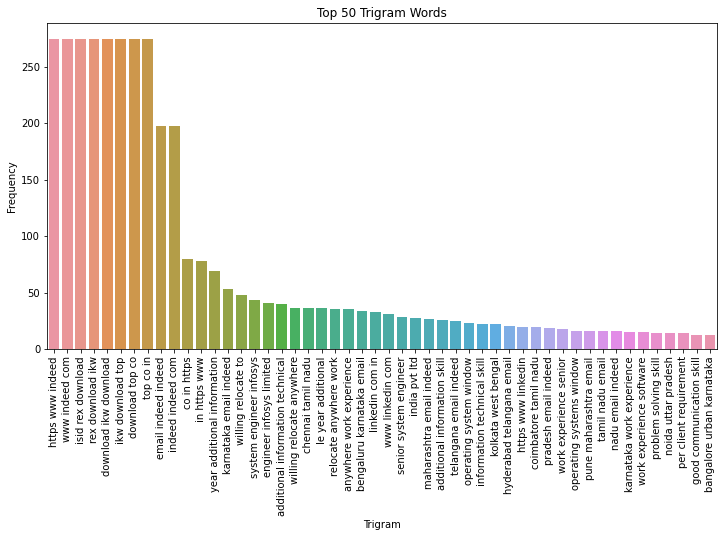

In [ ]:
plt.figure(figsize = (12, 6))
g = sns.barplot(data = df3, x = 'Trigram', y = 'Frequency');
g.set_xticklabels(df3['Trigram'], rotation=90)
plt.title('Top 50 Trigram Words')
plt.show()

## Distribution of Top 50 Part-of-Speech POS Tags

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
from textblob import TextBlob

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


In [ ]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [ ]:
blob = TextBlob(str(clean_resumes['content']))
blob.tags

[('0', 'CD'),
 ('govardhana', 'NN'),
 ('k', 'NN'),
 ('senior', 'JJ'),
 ('software', 'NN'),
 ('engineer', 'NN'),
 ('bengalur', 'NN'),
 ('1', 'CD'),
 ('harini', 'NN'),
 ('komaravelli', 'JJ'),
 ('test', 'NN'),
 ('analyst', 'NN'),
 ('oracle', 'NN'),
 ('hyderab', 'NN'),
 ('2', 'CD'),
 ('hartej', 'NN'),
 ('kathuria', 'NNS'),
 ('data', 'NNS'),
 ('analyst', 'NN'),
 ('intern', 'JJ'),
 ('oracle', 'NN'),
 ('ret', 'NN'),
 ('3', 'CD'),
 ('ijas', 'JJ'),
 ('nizamuddin', 'JJ'),
 ('associate', 'NN'),
 ('consultant', 'NN'),
 ('state', 'NN'),
 ('str', 'NN'),
 ('4', 'CD'),
 ('imgeeyaul', 'NN'),
 ('ansari', 'NN'),
 ('java', 'NN'),
 ('developer', 'NN'),
 ('pune', 'NN'),
 ('maharasht', 'NN'),
 ('195', 'CD'),
 ('mansi', 'NN'),
 ('thanki', 'NN'),
 ('student', 'NN'),
 ('jamnagar', 'NN'),
 ('gujarat', 'NN'),
 ('email', 'NN'),
 ('in', 'IN'),
 ('196', 'CD'),
 ('anil', 'JJ'),
 ('kumar', 'NN'),
 ('microsoft', 'JJ'),
 ('azure', 'NN'),
 ('basic', 'JJ'),
 ('management', 'NN'),
 ('de', 'NN'),
 ('197', 'CD'),
 ('siddhart

In [ ]:
pos_df = pd.DataFrame(blob.tags, columns = ['words', 'pos'])
pos_df.head()

,words,pos
0,0,CD
1,govardhana,NN
2,k,NN
3,senior,JJ
4,software,NN


In [ ]:
pos_df = pos_df['pos'].value_counts()
pos_df

NN     51
JJ     12
CD     11
NNS     2
NNP     1
IN      1
Name: pos, dtype: int64

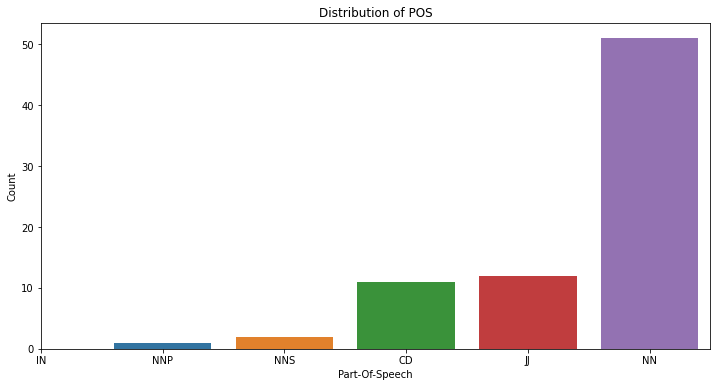

In [ ]:
plt.figure(figsize = (12, 6))
sns.barplot(data = pos_df, y = pos_df.index, x = pos_df.values);
labels = list(pos_df.index)
labels.reverse()
plt.xticks(np.arange(6) - 1.0, labels)
plt.title('Distribution of POS')
plt.ylabel('Count')
plt.xlabel('Part-Of-Speech')
plt.show();

## Word Cloud

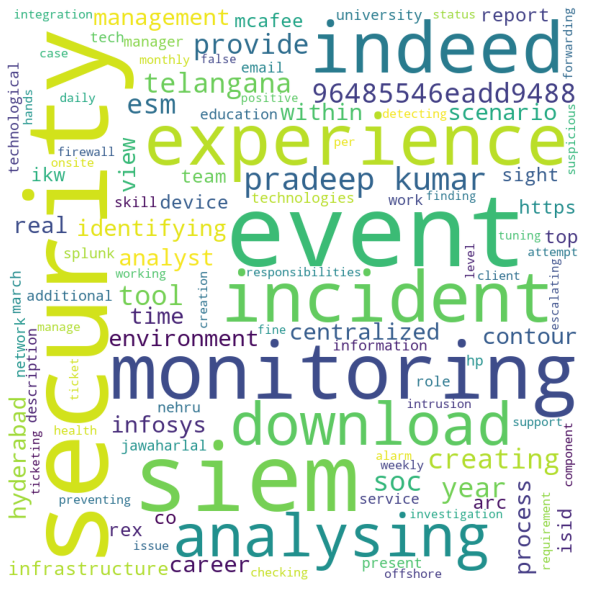

In [ ]:
#Final word cloud after all the cleaning and pre-processing
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
content_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for val in clean_resumes.content: 

   # typecaste each val to string 
   val = str(val) 

   # split the value 
   tokens = val.split() 

# Converts each token into lowercase 
for i in range(len(tokens)): 
    tokens[i] = tokens[i].lower() 

for words in tokens: 
    content_words = content_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(content_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

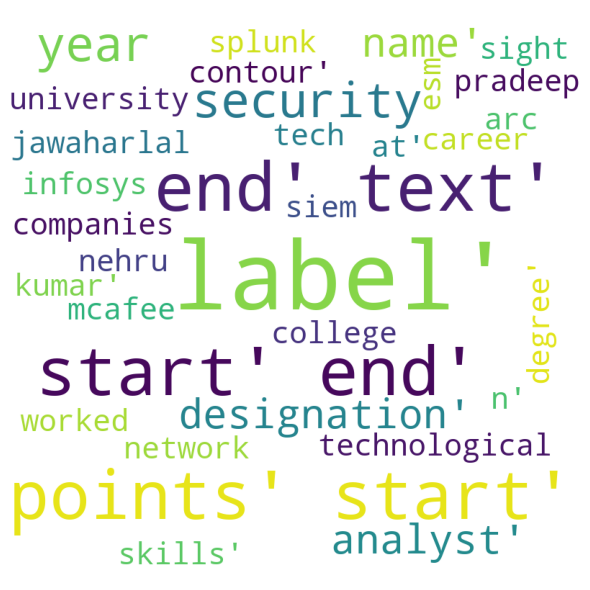

In [ ]:
#Final word cloud after all the cleaning and pre-processing
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
content_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for val in df.annotation: 

   # typecaste each val to string 
   val = str(val) 

   # split the value 
   tokens = val.split() 

# Converts each token into lowercase 
for i in range(len(tokens)): 
    tokens[i] = tokens[i].lower() 

for words in tokens: 
    content_words = content_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(content_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

### Zyad Al-Azazi

In [ ]:
# We obtain the frequency distribution of all the words and pick the 75 most frequently occurring words in all of 
# "resume corpus."

# %matplotlib notebook
from nltk import FreqDist
from collections import Iterable
import matplotlib.pyplot as plt

def flatten(lis):
     for item in lis:
        if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                yield x
        else:        
             yield item

tokenized_resumes = list(clean_resumes['content'])
#tokenized_resumes

for i in range(len(tokenized_resumes)):
    #print(type(tokenized_resumes[i]))
    tokenized_resumes[i] = str(tokenized_resumes[i]).split(" ")   
    
tokenized_resumes = list(flatten(tokenized_resumes))

freq_dist = FreqDist(tokenized_resumes)
freq_dist

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  


FreqDist({'govardhana': 1,
          'k': 4,
          'senior': 90,
          'software': 254,
          'engineer': 250,
          'bengaluru': 107,
          'karnataka': 196,
          'email': 232,
          'indeed:': 198,
          'indeed.com/r/govardhana-k/': 1,
          'b2de315d95905b68': 1,
          'total': 28,
          'experience': 508,
          '5': 64,
          'year': 644,
          '6': 71,
          'month': 74,
          'cloud': 103,
          'lending': 5,
          'solution': 184,
          'inc': 26,
          '4': 97,
          'salesforce': 10,
          'developer': 120,
          'oracle': 296,
          '2': 152,
          'core': 69,
          'java': 157,
          'language': 74,
          'go': 8,
          'lang': 2,
          'pl-sql': 6,
          'programming': 63,
          'sale': 122,
          'force': 9,
          'apex': 7,
          '': 3572,
          'designation': 4,
          '&': 328,
          'promotion': 6,
          'willing':

In [ ]:
# We obtain the frequency distribution of all the words and pick the 75 most frequently occurring words in all of 
# "resume corpus."

%matplotlib notebook
from nltk import FreqDist
from collections import Iterable
import matplotlib.pyplot as plt

def flatten(lis):
     for item in lis:
        if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                yield x
        else:        
             yield item

tokenized_resumes = list(clean_resumes['content'])
#tokenized_resumes

for i in range(len(tokenized_resumes)):
    #print(type(tokenized_resumes[i]))
    tokenized_resumes[i] = str(tokenized_resumes[i]).split(" ")   
    
tokenized_resumes = list(flatten(tokenized_resumes))

freq_dist = FreqDist(tokenized_resumes)
freq_dist

FreqDist({'': 3572, 'year': 644, 'management': 605, 'project': 564, 'team': 530, 'experience': 508, 'application': 471, 'skill': 435, 'system': 434, 'work': 418, ...})

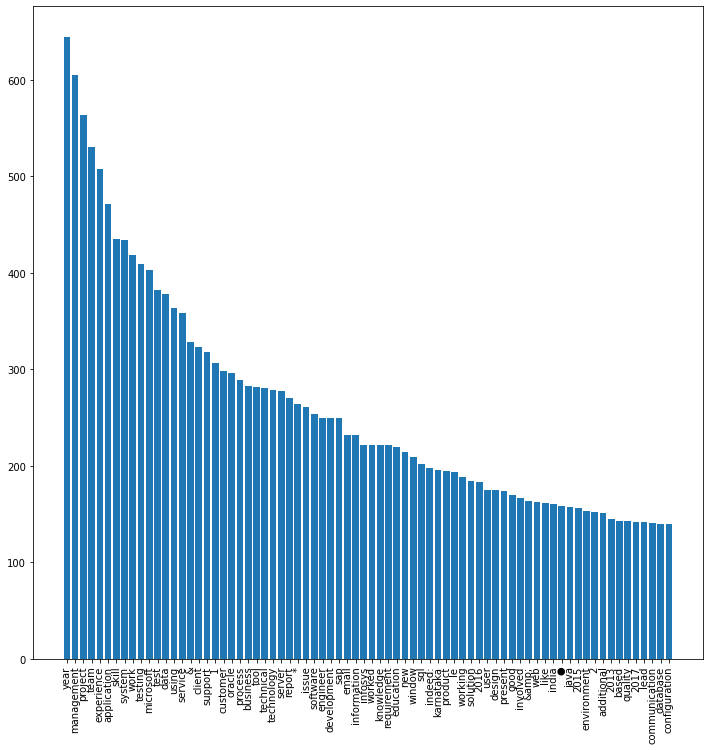

In [ ]:
# Plotting the word frequencies of the 75 most frequent words.

fd_common75 = freq_dist.most_common(75)

words = []
frequency = []

for i in range(1, 75):
    words.append(fd_common75[i][0]) 
    frequency.append(fd_common75[i][1])

plt.figure(figsize = (12, 12))
plt.bar(words, frequency)
plt.xticks(rotation = 90)
plt.show()

## Insights from the Bar Graph:
- The most mentioned companies on the applicants resumes were Microsoft and Oracle.
- Some of the keywords that the applicants emphasized on, in order, were management, data, testing, customer, business, technical and software.
- Under the assumption that all the applicants are applying to the same vacancy, we can hypothesize that this job is a leadership role that requires business and customer-communication skills accompanied with technical skills.
- The word “experience” was the 5th most frequent word, which demonstrates the high importance of experience over education in the job market.

In [ ]:
# Trying K-Means Clustering

from sklearn.cluster import KMeans
import numpy as np

def plot_clustering(data, labels, title=None):
    x_min, x_max = np.min(data, axis=0), np.max(data, axis=0)
    data = (data - x_min) / (x_max - x_min)
    fig = plt.figure(1, figsize=(4, 3))
    plt.figure(figsize=(6, 4))
    plt.scatter(data[:, 0], data[:, 1],
                 c=labels.astype(np.float))
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('on')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

tfidf_array = tf_idf.toarray()

kmeans = KMeans(n_clusters = 7)
kmeans.fit(tfidf_array)

labels = kmeans.labels_
plot_clustering(tfidf_array, labels);

plt.show();

#### The K-Means clustering does not seem to yield any useful insights or even represent the data. This is because of the high number of dimensions used to represent the data in the sample. 

### Reeka Hazarika

#### To visualize the texts, UMAP is used along with Seaborn and Matplotlib. It allowed us to get projections in 2D.
#### Using UMAP projections we tuned the vectorizer parameter (x) based on the iterative method.

In [ ]:
!pip install umap
!pip install scipy

  Created wheel for umap: filename=umap-0.1.1-cp37-none-any.whl size=3568 sha256=a2b0f0d596fce94d6b536dd05064948588893bb011f10531cb98b71ba176f3ae
  Stored in directory: /root/.cache/pip/wheels/7b/29/33/b4d917dc95f69c0a060e2ab012d95e15db9ed4cc0b94ccac26
Successfully built umap


In [ ]:
import umap
import scipy.cluster.hierarchy as shc

In [ ]:
import numpy as np
def get_umap(data, c=None, n_neighbors=50, min_dist=0.2, n_components=2, metric="cosine", title=""):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data)
    return u
data=tf_idf.tolist()
umap = get_umap(data)

df["umap_0"] = umap[:,0]
df["umap_1"] = umap[:,1]

<Figure size 720x504 with 0 Axes>

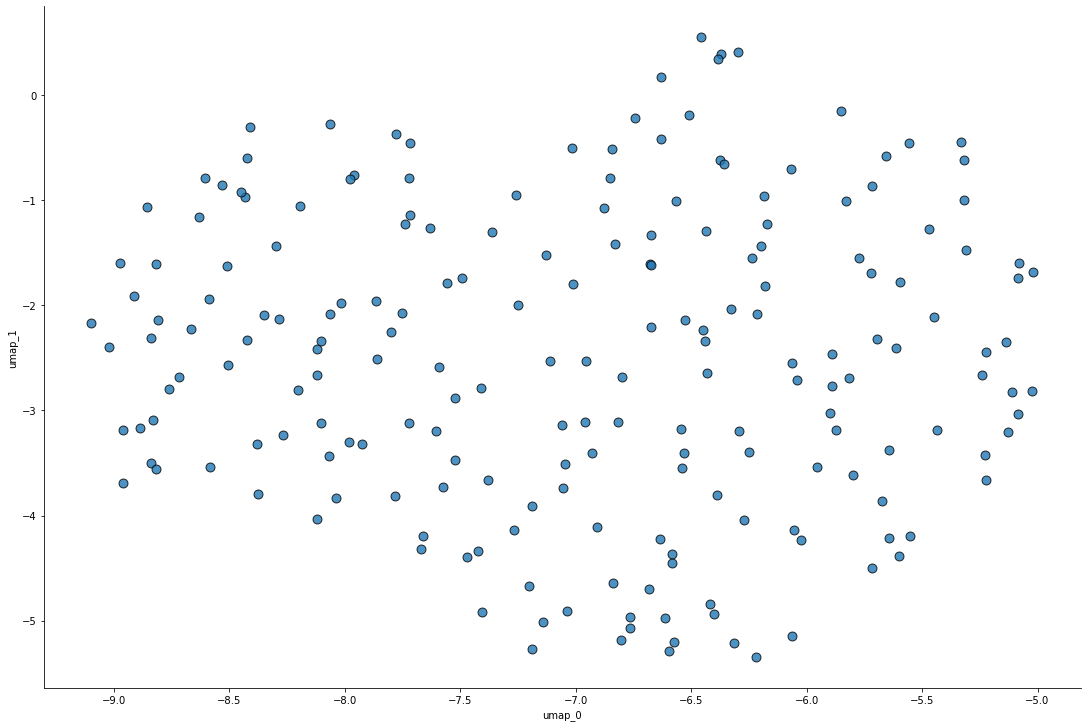

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,7))
sns.lmplot(x="umap_0",
          y="umap_1",
          data=df,
          fit_reg=False,
          legend=True,
          height=10,
          aspect=1.5,
          palette="gist_ncar",
          scatter_kws={'edgecolor':'k',
                      's':80})

#### The clusters have not come properly, hence we will use an unsupervised machine learning method which is called hierarchical clustering analysis.
#### Hierarchical clustering groups data over a variety of scales by creating a cluster tree or dendrogram. The tree is not a single set of clusters, but rather a multilevel hierarchy, where clusters at one level are joined as clusters at the next level.

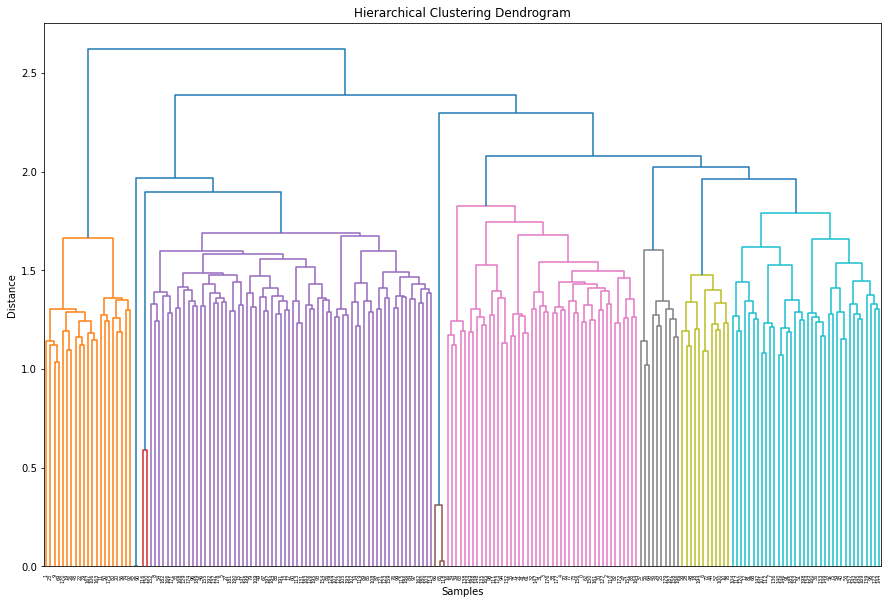

In [ ]:
Z = shc.linkage(data, method='ward')

plt.figure(figsize=(15,10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
dend = shc.dendrogram(Z)

#### The tree shows that we can split our data into 8 clusters.
#### To identify each clusters which group all features' values of resumes we added colours to each clusters.

In [ ]:
from scipy.cluster.hierarchy import fcluster

<Figure size 720x504 with 0 Axes>

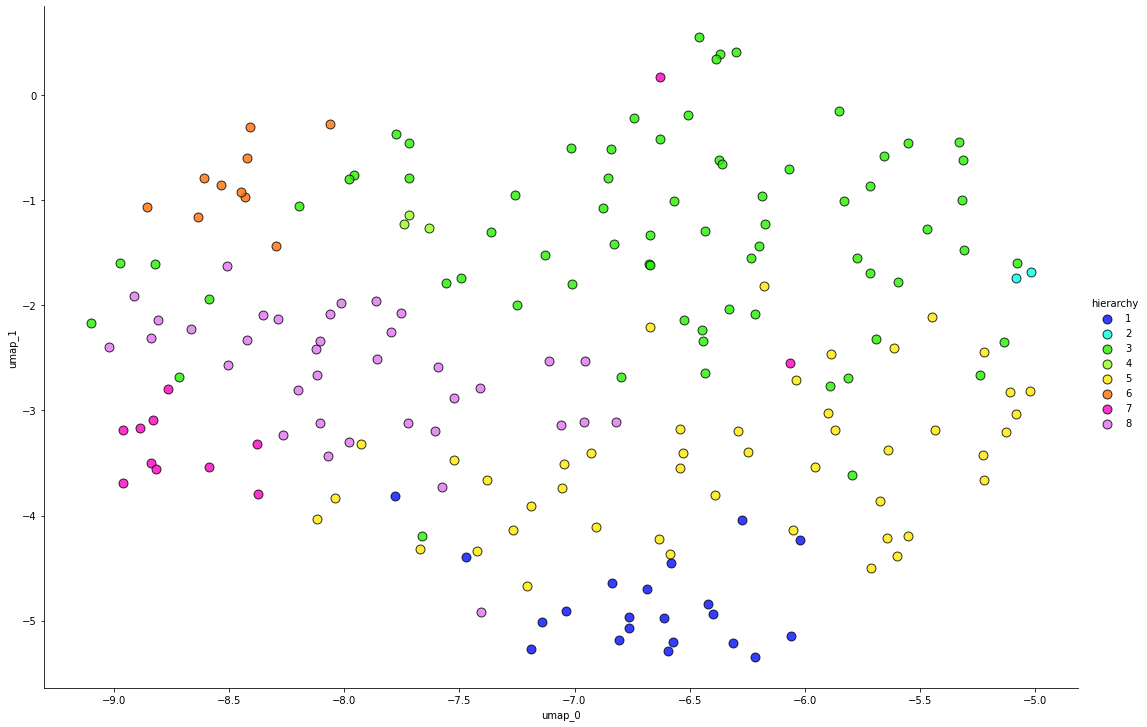

In [ ]:
k = 8
temp = fcluster(Z, k, criterion='maxclust')

df['hierarchy'] = temp

df_tf = pd.DataFrame(data, columns=vect.get_feature_names())
df_tf['hierarchy'] = temp

plt.figure(figsize=(10,7))
sns.lmplot(x="umap_0",
          y="umap_1",
          data=df,
          fit_reg=False,
          hue='hierarchy',
          legend=True,
          height=10,
          aspect=1.5,
          palette="gist_ncar",
          scatter_kws={'edgecolor':'k',
                      's':80})

#### We applied a method of how unstructured text data for a specific field, namely, recruiting can be organized. With the right feature engineering (TF-iDF transformation) it’s possible to split resumes into different groups (here we see 8 groups).

# Model Building:
### Reeka Hazarika
#### Resume Parsing with Custom NER Training Model with SpaCy:

In [ ]:
import spacy
import pickle
import random
import pandas as pd

In [ ]:
model_file="ner_model"
iterations=20

In [ ]:
df = pd.read_json('Resume.json', lines=True)
df.head()

,content,annotation
0,Govardhana K\nSenior Software Engineer\n\nBeng...,"[{'label': ['Companies worked at'], 'points': ..."
1,"Harini Komaravelli\nTest Analyst at Oracle, Hy...","[{'label': ['Companies worked at'], 'points': ..."
2,Hartej Kathuria\nData Analyst Intern - Oracle ...,"[{'label': ['Skills'], 'points': [{'start': 22..."
3,Ijas Nizamuddin\nAssociate Consultant - State ...,"[{'label': ['Skills'], 'points': [{'start': 46..."
4,"Imgeeyaul Ansari\njava developer\n\nPune, Maha...","[{'label': ['Skills'], 'points': [{'start': 18..."


In [ ]:
# Personal Custom Tags Dictionary
entity_dict = {
    'Name': 'NAME', 
    'College Name': 'CLG',
    'Degree': 'DEG',
    'Graduation Year': 'GRADYEAR',
    'Years of Experience': 'YOE',
    'Companies worked at': 'COMPANY',
    'Designation': 'DESIG',
    'Skills': 'SKILLS',
    'Location': 'LOC',
    'Email Address': 'EMAIL'
    }

In [ ]:
#For merging intervals the algorithm used:
#1. Sort the intervals in increasing order.
#2. Push the first interval on the stack.
#3. Iterate through intervals and for each one compare current interval with the top of the stack and:
    #A. If current interval does not overlap, push on to stack.
    #B. If current interval does overlap, merge both intervals in to one and push on to stack.
#4. At the end return stack.



def mergeIntervals(intervals):
    sorted_by_lower_bound = sorted(intervals, key=lambda tup: tup[0])
    merged = []
# lower and higher represent the bounds of the current run of merges
    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            # test for intersection between lower and higher:
            if higher[0] <= lower[1]: # new interval overlaps current run
                if lower[2] is higher[2]:
                    upper_bound = max(lower[1], higher[1]) # merge with the current run
                    merged[-1] = (lower[0], upper_bound, lower[2]) # replace by merged interval
                else:
                    if lower[1] > higher[1]:
                        merged[-1] = lower
                    else:
                        merged[-1] = (lower[0], higher[1], higher[2])
            else:
                merged.append(higher)

    return merged

In [ ]:
#From 'annotation' column, we are extracting the starting index, ending index and entity label

def get_entities(df):
    
    entities = []
    
    for i in range(len(df)):
        entity = []
    
        for annot in df['annotation'][i]:
            try:
                ent = entity_dict[annot['label'][0]]
                start = annot['points'][0]['start']
                end = annot['points'][0]['end'] + 1
                entity.append((start, end, ent))
            except:
                pass
    
        entity = mergeIntervals(entity)
        entities.append(entity)
    
    return entities

In [ ]:
# Adding a new column 'entities'
df['entities'] = get_entities(df)
df.head()

,content,annotation,entities
0,Govardhana K\nSenior Software Engineer\n\nBeng...,"[{'label': ['Companies worked at'], 'points': ...","[(0, 12, NAME), (13, 38, DESIG), (39, 48, LOC)..."
1,"Harini Komaravelli\nTest Analyst at Oracle, Hy...","[{'label': ['Companies worked at'], 'points': ...","[(0, 18, NAME), (19, 31, DESIG), (35, 41, COMP..."
2,Hartej Kathuria\nData Analyst Intern - Oracle ...,"[{'label': ['Skills'], 'points': [{'start': 22...","[(0, 15, NAME), (16, 35, DESIG), (38, 52, COMP..."
3,Ijas Nizamuddin\nAssociate Consultant - State ...,"[{'label': ['Skills'], 'points': [{'start': 46...","[(0, 15, NAME), (16, 36, DESIG), (39, 52, COMP..."
4,"Imgeeyaul Ansari\njava developer\n\nPune, Maha...","[{'label': ['Skills'], 'points': [{'start': 18...","[(0, 16, NAME), (17, 31, DESIG), (33, 37, LOC)..."


In [ ]:
a=[]

In [ ]:
for i in range(len(df)):
    a.append((df['content'][i],{'entities':df['entities'][i]}))

In [ ]:
import re


def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])

    return cleaned_data

In [ ]:
a = trim_entity_spans(a)

In [ ]:
nlp = spacy.blank('en')  
print("Created blank NLP model")

Created blank NLP model


In [ ]:
# Create NLP Pipeline
if 'ner' not in nlp.pipe_names:
    ner_pipe = nlp.add_pipe('ner')
else:
    ner_pipe = nlp.get_pipe('ner')

In [ ]:
# Add entities labels to the ner pipeline
for text, annotations in a:
    for entity in annotations.get('entities'):
        ner_pipe.add_label(entity[2].upper())

In [ ]:
from spacy.training.example import Example
# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
# train NER Model
with nlp.disable_pipes(*other_pipes):  # only train NER
    optimizer = nlp.initialize()
    for itn in range(iterations):
        print("Iteration Number:" + str(itn))
        random.shuffle(a)
        losses = {}
        for text, annotations in a:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            nlp.update([example], sgd=optimizer,losses=losses, drop=0.3)
            print("losses", losses)

Iteration Number:0
losses

C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Jatin Arora
SDET Automation Engineer, Infosys - CR..." with entities "[[0, 11, 'NAME'], [12, 36, 'DESIG'], [38, 45, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


 {'ner': 705.9523782730103}
losses {'ner': 2026.7511501312256}
losses {'ner': 2410.721460700035}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Ramya. P
Hyderabad, Telangana - Email me on Indeed..." with entities "[[0, 8, 'NAME'], [9, 18, 'LOC'], [52, 89, 'EMAIL']...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 3234.8656653165817}
losses {'ner': 3998.193949818611}
losses {'ner': 4357.604645371437}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Imgeeyaul Ansari
java developer

Pune, Maharashtra..." with entities "[[0, 16, 'NAME'], [17, 31, 'DESIG'], [33, 37, 'LOC...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 4689.266527295113}
losses {'ner': 4966.72038012743}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Madhava Konjeti
HR Executive

Bengaluru, Karnataka..." with entities "[[0, 15, 'NAME'], [16, 28, 'DESIG'], [30, 39, 'LOC...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 5351.214743793011}
losses {'ner': 5810.228366434574}
losses {'ner': 6025.167180597782}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Chhaya Prabhale
Kharadi, Pune, 411014, IN - Email ..." with entities "[[0, 15, 'NAME'], [16, 23, 'LOC'], [64, 110, 'EMAI...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 6090.526398763061}
losses {'ner': 6348.554473336495}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Nitin Tr
PeopleSoft Consultant

Bangalore Urban, K..." with entities "[[0, 8, 'NAME'], [32, 47, 'LOC'], [81, 119, 'EMAIL...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 6581.280598874844}
losses {'ner': 6659.5389874088}
losses {'ner': 6683.499087251352}
losses {'ner': 6703.297324465162}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Sharan Adla
- Email me on Indeed: indeed.com/r/Sha..." with entities "[[0, 11, 'NAME'], [34, 75, 'EMAIL'], [86, 91, 'YOE...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 6848.80220428326}
losses

C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Ashish Indoriya
Sr. Systems Engineer at Infosys Li..." with entities "[[0, 15, 'NAME'], [16, 36, 'DESIG'], [40, 55, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


 {'ner': 6860.682226331155}
losses {'ner': 6872.845388043977}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Palani S
Senior Technology Support Executive at In..." with entities "[[0, 8, 'NAME'], [9, 44, 'DESIG'], [48, 55, 'COMPA...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 6902.237652508487}
losses {'ner': 6975.903619130981}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Pavithra M
"Infosys" internship

Bengaluru, Karnat..." with entities "[[0, 10, 'NAME'], [12, 19, 'COMPANY'], [21, 31, 'D...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Asha Subbaiah
(Microsoft Partner Readiness Operati..." with entities "[[0, 13, 'NAME'], [15, 76, 'DESIG'], [79, 92, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 7160.505668057598}
losses {'ner': 7192.970678496455}
losses {'ner': 7227.883566651861}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Navas Koya
Test Engineer

Mangalore, Karnataka - E..." with entities "[[0, 10, 'NAME'], [11, 24, 'DESIG'], [26, 35, 'LOC...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Laya A
Cluster HR Manager - Velammal New

Chennai,..." with entities "[[0, 6, 'NAME'], [7, 25, 'DESIG'], [28, 40, 'COMPA...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 7240.106439462532}
losses

C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Madhuri Sripathi
Banglore, Karnataka, Karnataka - ..." with entities "[[0, 16, 'NAME'], [17, 25, 'LOC'], [62, 117, 'EMAI...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


 {'ner': 7310.0873190189195}
losses {'ner': 7367.295458438475}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Nitin Verma
Assisting Microsoft Partners - Exchang..." with entities "[[0, 11, 'NAME'], [12, 69, 'DESIG'], [71, 75, 'LOC...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Avani Priya
- Email me on Indeed: indeed.com/r/Ava..." with entities "[[0, 11, 'NAME'], [34, 75, 'EMAIL'], [94, 103, 'DE...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 7380.594932242027}
losses {'ner': 7397.615639833217}
losses {'ner': 7413.282020010993}
losses {'ner': 7477.565979980871}
losses {'ner': 7657.623809271499}
losses {'ner': 7663.849889642974}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Aarti Pimplay
Operations Center Shift Manager (OCS..." with entities "[[0, 13, 'NAME'], [14, 52, 'DESIG'], [76, 119, 'EM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "B. Gokul
Gokul, Uttar Pradesh - Email me on Indeed..." with entities "[[0, 8, 'LOC'], [9, 14, 'LOC'], [52, 89, 'EMAIL'],...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 7678.214162500655}
losses {'ner': 7728.737946016794}
losses {'ner': 7761.845642796856}
losses {'ner': 7927.354055754047}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Yogesh Ghatole
Engineer / Electrical Supervisor, S..." with entities "[[0, 14, 'NAME'], [15, 100, 'COMPANY'], [419, 452,...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 7942.282883872451}
losses {'ner': 7953.601604294543}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Dilliraja Baskaran
Tamil Nadu - Email me on Indeed..." with entities "[[0, 17, 'NAME'], [19, 29, 'LOC'], [52, 100, 'EMAI...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Kavya U.
Network Ops Associate - Accenture

Bengal..." with entities "[[0, 8, 'NAME'], [44, 53, 'LOC'], [87, 124, 'EMAIL...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 8000.299855301662}
losses {'ner': 8030.848246955895}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Srushti Bhadale
Mumbai, Maharashtra - Email me on ..." with entities "[[0, 15, 'NAME'], [16, 22, 'LOC'], [58, 103, 'EMAI...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 8053.756886740495}
losses {'ner': 8073.424179640169}
losses {'ner': 8109.23288407972}
losses {'ner': 8127.750506967022}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Priyesh Dubey
Azure Developer with 9 Yrs 8 months ..." with entities "[[0, 13, 'NAME'], [14, 29, 'DESIG'], [35, 48, 'YOE...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 8144.122295303801}
losses {'ner': 8179.197662439845}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Sai Dhir
- Email me on Indeed: indeed.com/r/Sai-Dh..." with entities "[[0, 8, 'NAME'], [31, 69, 'EMAIL'], [88, 124, 'LOC...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 8196.57995224803}
losses {'ner': 8265.425870497602}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Ravi Shankar
Working as Escalation Engineer with M..." with entities "[[0, 12, 'NAME'], [13, 43, 'DESIG'], [49, 58, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Ram Edupuganti
Software Development Director - Ora..." with entities "[[0, 14, 'NAME'], [15, 44, 'DESIG'], [47, 57, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 8311.671142186162}
losses {'ner': 8340.764057799017}
losses {'ner': 8353.642811121723}
losses {'ner': 8375.768553225906}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "amarjyot sodhi
Voice and Accent Trainer :Masters i..." with entities "[[0, 14, 'NAME'], [15, 39, 'DESIG'], [41, 80, 'DEG...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 8428.579180464905}
losses {'ner': 8444.957776035857}
losses {'ner': 8474.718716975387}
losses {'ner': 8499.354440489144}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Nidhi Pandit
Test Engineer - Infosys Limited

- Em..." with entities "[[0, 12, 'NAME'], [13, 26, 'DESIG'], [29, 44, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 8523.856671501226}
losses {'ner': 8554.205400808314}
losses {'ner': 8598.922415735033}
losses {'ner': 8616.785773753934}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Rahul Tayade
Global Production Support Lead, - Inf..." with entities "[[0, 12, 'NAME'], [13, 43, 'DESIG'], [47, 58, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 8640.16130991634}
losses {'ner': 8667.721490202723}
losses {'ner': 8692.09936224869}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Raktim Podder
6+ Exp in banking operations and cre..." with entities "[[0, 13, 'NAME'], [14, 16, 'YOE'], [66, 70, 'LOC']...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 8712.68257062654}
losses {'ner': 8725.910094588162}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Ajay Elango
Software Engineer

Bangalore City, Kar..." with entities "[[717, 748, 'CLG'], [6642, 6696, 'DEG'], [6698, 67...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 8733.343795769408}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Anurag Asthana
Pune, Maharashtra - Email me on Ind..." with entities "[[0, 14, 'NAME'], [15, 19, 'LOC'], [55, 99, 'EMAIL...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 8777.266899241633}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Debasish Dasgupta
Trainer-Finacle-Core Banking Sol..." with entities "[[0, 17, 'NAME'], [18, 56, 'DESIG'], [57, 64, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 8789.911020241758}
losses {'ner': 8814.138080767378}
losses {'ner': 8832.43432799598}
losses {'ner': 8852.732071293094}
losses {'ner': 8877.629402435767}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Jacob Philip
Kottayam, Kerala - Email me on Indeed..." with entities "[[0, 12, 'NAME'], [13, 21, 'LOC'], [52, 94, 'EMAIL...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 8887.870657250303}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Akshay Dubey
Actively looking for opportunity in ...." with entities "[[0, 12, 'NAME'], [67, 71, 'LOC'], [107, 149, 'EMA...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Sudaya Puranik
Principal Engineer Technical Staff ..." with entities "[[0, 14, 'NAME'], [15, 49, 'DESIG'], [52, 61, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 9048.560381636042}
losses {'ner': 9084.261971808057}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Ramesh HP
CES ASSOCIATE CONSULTANT

Bangalore, Kar..." with entities "[[0, 9, 'NAME'], [10, 34, 'DESIG'], [36, 45, 'LOC'...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 9108.633108044825}
losses {'ner': 9125.98376916056}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Roshan Sinha
Application Developer - SAP ABAP

Kol..." with entities "[[0, 12, 'NAME'], [13, 34, 'DESIG'], [37, 45, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Kavitha K
Senior System Engineer - Infosys Limited..." with entities "[[0, 9, 'NAME'], [10, 32, 'DESIG'], [35, 50, 'COMP...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 9200.954392179596}
losses {'ner': 9257.82786694916}
losses {'ner': 9316.828533605021}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Sridevi H
Bangalore, Karnataka - Email me on Indee..." with entities "[[0, 9, 'NAME'], [10, 19, 'LOC'], [53, 92, 'EMAIL'...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 9348.288825574262}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Yathishwaran P
Maximo Consultant - Infosys Limited..." with entities "[[0, 14, 'NAME'], [15, 32, 'DESIG'], [35, 50, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 9387.444990686537}
losses {'ner': 9398.752485670439}
losses {'ner': 9415.395141000829}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Arpit Jain
Quality Analyst - ThoughtWorks Technolo..." with entities "[[0, 10, 'NAME'], [11, 26, 'DESIG'], [29, 54, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 9445.475058098948}
losses {'ner': 9479.538925074901}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Soumya Balan
IT SUPPORT

Sulthan Bathery, Kerala, ..." with entities "[[0, 12, 'NAME'], [13, 23, 'DESIG'], [25, 40, 'LOC...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 9514.948814575577}
losses {'ner': 9526.68834307526}
losses {'ner': 9542.521190747422}
losses {'ner': 9559.617446651537}
losses {'ner': 9572.244866267274}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Jyotirbindu Patnaik
Associate consultant@SAP labs ..." with entities "[[0, 40, 'DESIG'], [73, 82, 'LOC'], [116, 166, 'EM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Mayank Shukla
Infosys group as a Test Analyst - In..." with entities "[[0, 13, 'NAME'], [33, 45, 'DESIG'], [48, 81, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 9599.188134143673}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Mohammed Murtuza
Major Incident Manager / Escalati..." with entities "[[0, 16, 'NAME'], [17, 60, 'DESIG'], [63, 78, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 9615.8372413971}
losses {'ner': 9647.707617384656}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Srinivas VO
Sr. Test Manager

Mumbai, Maharashtra ..." with entities "[[0, 11, 'NAME'], [12, 28, 'DESIG'], [30, 36, 'LOC...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 9672.448895930762}
losses {'ner': 9682.534348570405}
losses {'ner': 9739.684122417415}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Mohini Gupta
Server Support Engineer

Gurgaon, Har..." with entities "[[0, 12, 'NAME'], [13, 36, 'DESIG'], [38, 45, 'LOC...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Nida Khan
Tech Support Executive - Teleperformance..." with entities "[[0, 32, 'DESIG'], [35, 64, 'COMPANY'], [66, 72, '...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 9787.97711682253}
losses {'ner': 9805.667654073663}
losses {'ner': 9814.656119297784}
losses {'ner': 9830.708577757407}
losses {'ner': 9934.773129468489}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Gunjan Nayyar
Hoshiarpur, Punjab - Email me on Ind..." with entities "[[0, 13, 'NAME'], [14, 24, 'LOC'], [55, 98, 'EMAIL...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 9971.01759275427}
losses {'ner': 10015.325952404179}
losses

C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Divesh Singh
Bengaluru, Karnataka - Email me on In..." with entities "[[0, 12, 'NAME'], [13, 22, 'LOC'], [56, 98, 'EMAIL...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Puneeth R
Escalation Specialist - HiPower Support ..." with entities "[[0, 9, 'NAME'], [10, 31, 'DESIG'], [34, 56, 'COMP...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


 {'ner': 10106.685875598982}
losses {'ner': 10119.366180901903}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Vishwanath P
Senior Executive (MIS & Audit) - Job ..." with entities "[[0, 12, 'NAME'], [13, 43, 'DESIG'], [61, 93, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 10133.063287289751}
losses {'ner': 10186.767439790467}
losses {'ner': 10199.938685539415}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Praveen Bhaskar
Program Manager (Software Delivery..." with entities "[[0, 15, 'NAME'], [16, 51, 'DESIG'], [54, 67, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Rajeev Kumar
Senior Associate Consultant - Infosys..." with entities "[[0, 12, 'NAME'], [13, 40, 'DESIG'], [43, 64, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 10401.728394675305}
losses {'ner': 10437.309584553532}
losses {'ner': 10449.093592881281}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Vinay Singhal
New Delhi, Delhi - Email me on Indee..." with entities "[[0, 13, 'NAME'], [14, 23, 'LOC'], [53, 96, 'EMAIL...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Krishna Prasad
Patna, Bihar - Email me on Indeed: ..." with entities "[[0, 14, 'NAME'], [15, 20, 'LOC'], [50, 94, 'EMAIL...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 10478.109860623028}
losses {'ner': 10502.247335342197}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Sanand Pal
SQL and MSBI Developer with experience ..." with entities "[[0, 10, 'NAME'], [11, 33, 'DESIG'], [85, 95, 'LOC...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Pankaj Bhosale
Microsoft SQL-SERVER

Dhule, Mahara..." with entities "[[0, 14, 'NAME'], [15, 35, 'DESIG'], [37, 42, 'LOC...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 10525.296215302978}
losses {'ner': 10547.291763525396}
losses {'ner': 10592.713908666921}
losses {'ner': 10613.442872411682}
losses {'ner': 10640.71147690061}
losses {'ner': 10659.584330910106}
losses {'ner': 10674.446837709766}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Pawan Nag
Microsoft Certified System Engineer

Del..." with entities "[[0, 9, 'NAME'], [10, 19, 'DESIG'], [20, 45, 'DESI...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Karthik G V
Program Manager, Product Manager, Prod..." with entities "[[0, 11, 'NAME'], [12, 28, 'DESIG'], [136, 149, 'L...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 10706.835253120342}
losses {'ner': 10729.249650895525}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Saurabh Sandhikar
SAURABH SANDHIKAR

Hyderabad, Te..." with entities "[[0, 17, 'NAME'], [37, 46, 'LOC'], [80, 128, 'EMAI...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Puran Mal
Jaipur, Rajasthan - Email me on Indeed: ..." with entities "[[0, 9, 'NAME'], [10, 16, 'LOC'], [50, 89, 'EMAIL'...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 10737.5033995033}
losses {'ner': 10747.799445488838}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Koushik Katta
Devops

Hyderabad, Telangana - Email..." with entities "[[0, 13, 'NAME'], [22, 31, 'LOC'], [65, 108, 'EMAI...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 10785.196814981695}
losses {'ner': 10800.185790040798}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Paul Rajiv
Secunderabad, Andhra Pradesh - Email me..." with entities "[[0, 10, 'NAME'], [11, 23, 'LOC'], [62, 103, 'EMAI...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 10814.894126484069}
losses {'ner': 10843.236628211002}
losses {'ner': 10853.718148259139}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Keshav Dhawale
3 TCS Security guard Access Control..." with entities "[[0, 14, 'NAME'], [17, 35, 'DESIG'], [56, 62, 'YOE...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 10899.412646956842}
losses {'ner': 10918.069836480927}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Tejasri Gunnam
Bengaluru, Karnataka - Email me on ..." with entities "[[0, 14, 'NAME'], [15, 24, 'LOC'], [58, 102, 'EMAI...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 10935.561869523575}
losses {'ner': 10962.699566922878}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Rupesh Reddy
Technology Consultant - EIT Services ..." with entities "[[0, 12, 'NAME'], [13, 34, 'DESIG'], [37, 71, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 10980.49944901703}
losses {'ner': 11026.833000199093}
losses {'ner': 11057.966096992568}
losses {'ner': 11083.579808801922}
losses {'ner': 11102.827012588497}
losses

C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Zaheer Uddin
Technical Project Manager

Hyderabad,..." with entities "[[0, 12, 'NAME'], [13, 38, 'DESIG'], [40, 49, 'LOC...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


 {'ner': 11392.175208916184}
losses {'ner': 11421.122370293446}
losses {'ner': 11448.398108562678}
losses {'ner': 11452.635086543167}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Sohan Dhakad
Shivpuri, Madhya Pradesh - Email me o..." with entities "[[0, 12, 'NAME'], [13, 21, 'LOC'], [60, 103, 'EMAI...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 11480.516213157294}
losses {'ner': 11492.897603979878}
losses {'ner': 11513.829212812307}
losses

C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Fenil Francis
head of operation and logistics

Tri..." with entities "[[0, 13, 'NAME'], [14, 45, 'DESIG'], [47, 55, 'LOC...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


 {'ner': 11526.856796691476}
losses {'ner': 11561.037665438653}
losses {'ner': 11574.701285361803}
losses {'ner': 11634.092772398155}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Pratibha P
Principal Consultant at Oracle

Bengalu..." with entities "[[0, 10, 'NAME'], [11, 31, 'DESIG'], [35, 41, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Puneet Singh
Associate Software Engineer

Bengalur..." with entities "[[0, 12, 'NAME'], [13, 40, 'DESIG'], [42, 51, 'LOC...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 11664.418445098767}
losses {'ner': 11677.163298597443}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Jaspreet Kaur
Oceanic Consultants as a HR Executiv..." with entities "[[0, 13, 'NAME'], [14, 33, 'COMPANY'], [39, 51, 'C...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 11699.06338540162}
losses {'ner': 11751.63314680825}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Mahesh Vijay
Bengaluru, Karnataka - Email me on In..." with entities "[[0, 12, 'NAME'], [13, 22, 'LOC'], [56, 98, 'EMAIL...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 11778.299456758803}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Girish Acharya
Technical Architect & Sr. Software ..." with entities "[[0, 14, 'NAME'], [15, 58, 'DESIG'], [60, 64, 'LOC...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 11872.003917744762}
losses {'ner': 11883.252706008749}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Shraddha Achar
Mathura, Uttar Pradesh - Email me o..." with entities "[[0, 14, 'NAME'], [15, 22, 'LOC'], [60, 105, 'EMAI...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 11920.889429349383}
losses {'ner': 11950.3932368661}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Urshila Lohani
Senior Corporate Account Executive ..." with entities "[[0, 14, 'NAME'], [15, 49, 'DESIG'], [52, 59, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 11992.989344004189}
losses {'ner': 12003.122376007812}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Akansha Jain
Pune, Maharashtra - Email me on Indee..." with entities "[[0, 12, 'NAME'], [13, 18, 'LOC'], [53, 95, 'EMAIL...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 12045.45518113517}
losses {'ner': 12067.702776910746}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Suresh Kanagala
Architecture SharePoint/Office 365..." with entities "[[0, 15, 'NAME'], [70, 79, 'LOC'], [113, 159, 'EMA...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Pradeeba V
LEAD ENGINEER - CISCO

- Email me on In..." with entities "[[0, 10, 'NAME'], [11, 24, 'DESIG'], [27, 32, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 12232.147323312247}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "PRASHANTH BADALA
Devops Engineer ,Cloud Engineer -..." with entities "[[0, 16, 'NAME'], [17, 32, 'DESIG'], [34, 48, 'DES...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 12383.648692370605}
losses {'ner': 12420.328347767472}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Suman Biswas
SAP UI5 Lead, Native HANA Developer -..." with entities "[[0, 12, 'NAME'], [13, 48, 'DESIG'], [51, 68, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 12628.933621252656}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Shreyanshu Gupta
Software Development Engineer wit..." with entities "[[0, 16, 'NAME'], [17, 46, 'DESIG'], [52, 60, 'YOE...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 12748.615109780769}
losses {'ner': 12905.494412044029}
losses {'ner': 12914.66662724029}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Sameer Kujur
Orrisha - Email me on Indeed: indeed...." with entities "[[0, 12, 'NAME'], [13, 20, 'LOC'], [43, 85, 'EMAIL...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Arpit Godha
Senior Process Executive

Jaipur, Raja..." with entities "[[0, 11, 'NAME'], [12, 36, 'DESIG'], [38, 44, 'LOC...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 12924.902368272178}
losses {'ner': 12948.898777668479}
losses {'ner': 12992.341077874562}
losses {'ner': 13005.086258822887}
losses {'ner': 13034.85300703889}
losses {'ner': 13044.743335820669}
losses

C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Chaban kumar Debbarma
Tripura - Email me on Indeed..." with entities "[[0, 21, 'NAME'], [22, 29, 'LOC'], [52, 103, 'EMAI...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Ganesh AlalaSundaram
A Dev-Test Professional with ..." with entities "[[0, 20, 'NAME'], [50, 56, 'YOE'], [129, 136, 'LOC...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


 {'ner': 13053.519375488468}
losses {'ner': 13063.987145276496}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Vineeth Vijayan
"Store Executive" - Orange City Ho..." with entities "[[0, 15, 'NAME'], [17, 32, 'DESIG'], [36, 77, 'CLG...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 13079.49116059802}
losses {'ner': 13090.330858023553}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Karthik Gururaj
Technical Lead at Infosys Ltd. - P..." with entities "[[0, 15, 'NAME'], [16, 30, 'DESIG'], [34, 45, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 13118.37393491354}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Senthil Kumar
Senior Technical Lead - HCL Cisco

-..." with entities "[[0, 13, 'NAME'], [14, 35, 'DESIG'], [38, 47, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 13171.997197157629}
losses {'ner': 13191.014445542449}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Shaik Tazuddin
Senior Process Executive - STAR Ind..." with entities "[[0, 14, 'NAME'], [15, 39, 'DESIG'], [42, 52, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Hartej Kathuria
Data Analyst Intern - Oracle Retai..." with entities "[[0, 15, 'NAME'], [16, 35, 'DESIG'], [38, 51, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 13213.976998403223}
losses {'ner': 13508.390284203464}
losses {'ner': 13517.747805027537}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Angad Waghmare
Pune, Maharashtra - Email me on Ind..." with entities "[[0, 14, 'NAME'], [15, 19, 'LOC'], [55, 99, 'EMAIL...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Siddhartha Chetri
7 years of experience in IT Netw..." with entities "[[0, 17, 'NAME'], [18, 25, 'YOE'], [270, 279, 'LOC...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 13530.339143685178}
losses {'ner': 13539.105057300374}
losses {'ner': 13558.62563409481}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "VARUN AHLUWALIA
Quantitative Analyst

- Email me o..." with entities "[[0, 15, 'NAME'], [16, 36, 'DESIG'], [61, 105, 'EM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 13571.14104169837}
losses {'ner': 13586.75812938125}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Kandrapu Reddy
Senior Travel Operations (Domestic,..." with entities "[[0, 14, 'NAME'], [15, 39, 'DESIG'], [78, 112, 'CO...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 13605.631023284841}
losses {'ner': 13630.856387561307}
losses {'ner': 13668.674157222442}
losses {'ner': 13766.646312238237}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Ravi Shivgond
Bidar, Karnataka - Email me on Indee..." with entities "[[0, 13, 'NAME'], [14, 19, 'LOC'], [53, 96, 'EMAIL...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Abdul B
Arabic Language supporter (Content Analyst..." with entities "[[0, 7, 'NAME'], [8, 51, 'DESIG'], [53, 62, 'LOC']...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 14023.221164526007}
losses {'ner': 14032.924731436637}


C:\Users\HAZARIKA\anaconda3\lib\site-packages\spacy\training\iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "Puneet Bhandari
SAP SD lead - Microsoft IT

Pune, ..." with entities "[[0, 15, 'NAME'], [16, 27, 'DESIG'], [30, 39, 'COM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


losses {'ner': 14057.097177549047}
Iteration Number:1
losses {'ner': 105.85099158454989}
losses {'ner': 124.55173535955885}
losses {'ner': 152.2732185605542}
losses {'ner': 160.9754192692431}
losses {'ner': 178.0629522499599}
losses {'ner': 313.4947897714533}
losses {'ner': 330.6059505692756}
losses {'ner': 522.9643417648113}
losses {'ner': 589.4688451383622}
losses {'ner': 619.9523355290224}
losses {'ner': 829.6761819645693}
losses {'ner': 940.1204932257464}
losses {'ner': 949.1649607931151}
losses {'ner': 969.7402001991057}
losses {'ner': 978.3708151647884}
losses {'ner': 989.074995622763}
losses {'ner': 998.7601428098756}
losses {'ner': 1048.8173667125634}
losses {'ner': 1062.8238873265877}
losses {'ner': 1139.5455133028522}
losses {'ner': 1162.5027248345318}
losses {'ner': 1248.8131962081598}
losses {'ner': 1269.5704594221152}
losses {'ner': 1297.2705359889926}
losses {'ner': 1311.6292817480946}
losses {'ner': 1329.0771128914407}
losses {'ner': 1340.077146532703}
losses {'ner': 134

In [ ]:
nlp.to_disk('nlp_ner_model')

In [ ]:
nlp_model = spacy.load('nlp_ner_model')

In [ ]:
a[1][0]

'Urshila Lohani\nSenior Corporate Account Executive - MongoDB\n\nGurgaon, Haryana - Email me on Indeed: indeed.com/r/Urshila-Lohani/ab8d3dc6dd8b13f0\n\nWilling to relocate: Anywhere\n\nWORK EXPERIENCE\n\nSenior Corporate Account Executive\n\nMongoDB -  Gurgaon, Haryana -\n\nMay 2016 to Present\n\n• Designed and implemented a 2-year sales strategy for South India Region; revenues grew 4X.\n• Trained sales team of 35 from 20 partner companies; revenues generated through partners\nincreased 50%.\n• Led Business development team of 5 to build pipeline of 4X.\n• Acquired 32 new accounts with industry leaders including Intuit, IBM, Wipro, McAfee, Airtel,\nReligare and Adobe; 100% renewals in all existing accounts.\n• Initiated, designed and executed marketing events; attendees included 200 IT heads;\ngenerated $1M\npipeline.\n• Ranked in top 5% of global sales team of 322; Awarded thrice for highest quarterly revenues\nin APAC.\n• Won Excellence Club Award in FY17 and FY18.\n\nAccount Manage

In [ ]:
doc = nlp_model(a[1][0])
for ent in doc.ents:
    print(f'{ent.label_.upper():{30}}- {ent.text}')

NAME                          - Urshila Lohani
DESIG                         - Senior Corporate Account Executive
COMPANY                       - MongoDB
LOC                           - Gurgaon
EMAIL                         - indeed.com/r/Urshila-Lohani/ab8d3dc6dd8b13f0
DESIG                         - Senior Corporate Account Executive
COMPANY                       - MongoDB
LOC                           - Gurgaon
DESIG                         - Account Manager
LOC                           - Bengaluru
DESIG                         - Account Manager
COMPANY                       - Oracle
LOC                           - Noida
GRADYEAR                      - 2014
DESIG                         - Business Development Rep
COMPANY                       - Oracle
COMPANY                       - Oracle
COMPANY                       - Oracle
COMPANY                       - Oracle
DEG                           - B Tech Honors in Technical
CLG                           - College of Engineering
GRA

# Model Training & Prediction
### Swapnil Vishwakarma


In [7]:
# Required Library
# !pip install seqeval==0.0.12

# Importing required Libraries
import pandas as pd
import math
import numpy as np
import os
import json
import random
import logging
import re
import spacy
import random

# data_file_address = '/content/Resume.json'
# df_data = pd.read_json(data_file_address, lines=True)
# Removing New Line characters
for i in range(len(df)):
  df["content"][i] = df["content"][i].replace("\n", " ")

# JSON formatting functions
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    try:
        training_data = []
        lines=[]
        with open(dataturks_JSON_FilePath, encoding="utf-8") as f:
            lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content'].replace("\n", " ")
            entities = []
            data_annotations = data['annotation']
            if data_annotations is not None:
                for annotation in data_annotations:
                    #only a single point in text annotation.
                    point = annotation['points'][0]
                    labels = annotation['label']
                    # handle both list of labels or a single label.
                    if not isinstance(labels, list):
                        labels = [labels]

                    for label in labels:
                        point_start = point['start']
                        point_end = point['end']
                        point_text = point['text']
                        
                        lstrip_diff = len(point_text) - len(point_text.lstrip())
                        rstrip_diff = len(point_text) - len(point_text.rstrip())
                        if lstrip_diff != 0:
                            point_start = point_start + lstrip_diff
                        if rstrip_diff != 0:
                            point_end = point_end - rstrip_diff
                        entities.append((point_start, point_end + 1 , label))
            training_data.append((text, {"entities" : entities}))
        return training_data
    except Exception as e:
        logging.exception("Unable to process " + dataturks_JSON_FilePath + "\n" + "error = " + str(e))
        return None

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data


### Spacy Entity Interaction

In [9]:
data = trim_entity_spans(convert_dataturks_to_spacy(source_file))
data[0]

['Govardhana K Senior Software Engineer  Bengaluru, Karnataka, Karnataka - Email me on Indeed: indeed.com/r/Govardhana-K/ b2de315d95905b68  Total IT experience 5 Years 6 Months Cloud Lending Solutions INC 4 Month • Salesforce Developer Oracle 5 Years 2 Month • Core Java Developer Languages Core Java, Go Lang Oracle PL-SQL programming, Sales Force Developer with APEX.  Designations & Promotions  Willing to relocate: Anywhere  WORK EXPERIENCE  Senior Software Engineer  Cloud Lending Solutions -  Bangalore, Karnataka -  January 2018 to Present  Present  Senior Consultant  Oracle -  Bangalore, Karnataka -  November 2016 to December 2017  Staff Consultant  Oracle -  Bangalore, Karnataka -  January 2014 to October 2016  Associate Consultant  Oracle -  Bangalore, Karnataka -  November 2012 to December 2013  EDUCATION  B.E in Computer Science Engineering  Adithya Institute of Technology -  Tamil Nadu  September 2008 to June 2012  https://www.indeed.com/r/Govardhana-K/b2de315d95905b68?isid=rex-

## Splitting into Train & Test Data
### Training the model

In [ ]:
# Splitting the data into train and test data
train_data = data[:180]
test_data = data[180:]

#Training inatilize
nlp = spacy.blank('en')
iterations = 29
def train_model(train_data):
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last = True)
    
    for _, annotation in train_data:
        for ent in annotation['entities']:
            ner.add_label(ent[2])
            
    
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(iterations):
            print("Statring iteration " + str(itn))
            random.shuffle(train_data)
            losses = {}
            index = 0
            for text, annotations in train_data:
                try:
                    nlp.update(
                        [text],  # batch of texts
                        [annotations],  # batch of annotations
                        drop=0.02,  # dropout - make it harder to memorise data
                        sgd=optimizer,  # callable to update weights
                        losses=losses)
                except Exception as e:
                    pass
                
            print(losses)

# Model Training
train_model(train_data)

Statring iteration 0
{'ner': 19295.78225661238}
Statring iteration 1
{'ner': 11223.219874153798}
Statring iteration 2
{'ner': 7588.150010439162}
Statring iteration 3
{'ner': 7372.751485189425}
Statring iteration 4
{'ner': 6257.481414406864}
Statring iteration 5
{'ner': 5096.217983710912}
Statring iteration 6
{'ner': 4472.030467791515}
Statring iteration 7
{'ner': 4152.602106504588}
Statring iteration 8
{'ner': 4734.381594760141}
Statring iteration 9
{'ner': 4324.07220801348}
Statring iteration 10
{'ner': 3589.2478849928257}
Statring iteration 11
{'ner': 3940.280747577216}
Statring iteration 12
{'ner': 3781.4001033318787}
Statring iteration 13
{'ner': 2766.1297532349695}
Statring iteration 14
{'ner': 2703.141443368808}
Statring iteration 15
{'ner': 2671.682105088017}
Statring iteration 16
{'ner': 2676.5810315242256}
Statring iteration 17
{'ner': 2274.2366196055846}
Statring iteration 18
{'ner': 1998.5806555174586}
Statring iteration 19
{'ner': 2461.360916152195}
Statring iteration 20
{'

### Save and Load the model

In [ ]:
# Saving  model in disk
nlp.to_disk('nlp_model')

# Loading the model
nlp_model = spacy.load('nlp_model')

In [ ]:
import re
import spacy
import random

# Extracting Mobile Nnumber

def extract_mobile_number(text):
    phone = re.findall(re.compile(r'(?:(?:\+?([1-9]|[0-9][0-9]|[0-9][0-9][0-9])\s*(?:[.-]\s*)?)?(?:\(\s*([2-9]1[02-9]|[2-9][02-8]1|[2-9][02-8][02-9])\s*\)|([0-9][1-9]|[0-9]1[02-9]|[2-9][02-8]1|[2-9][02-8][02-9]))\s*(?:[.-]\s*)?)?([2-9]1[02-9]|[2-9][02-9]1|[2-9][02-9]{2})\s*(?:[.-]\s*)?([0-9]{4})(?:\s*(?:#|x\.?|ext\.?|extension)\s*(\d+))?'), text)
    
    if phone:
        number = ''.join(phone[0])
        if len(number) > 10:
            return '+' + number
        else:
            return number

def resumeData(text,model):
    '''
    Data should be in the Format demonstrated in test mode 
    
    '''
    nlp_model = spacy.load(model)
    doc = nlp_model(text)
    for ent in doc.ents:
        print(f'{ent.label_.upper():{30}}- {ent.text}')
    
    ph_number = extract_mobile_number(text)
    if ph_number:
      print(f"PHONE NUMBER                  - {ph_number}")

### Testing

In [ ]:
# Checking Test Data
test_data

[['Chaban kumar Debbarma Tripura - Email me on Indeed: indeed.com/r/Chaban-kumar-Debbarma/bf721c55fb380d19  Willing to relocate to: Agartala, Tripura - Tripura  WORK EXPERIENCE  Microsoft  -  June 2018 to December 2018  I want full time jobs  EDUCATION  10th  School  https://www.indeed.com/r/Chaban-kumar-Debbarma/bf721c55fb380d19?isid=rex-download&ikw=download-top&co=IN',
  {'entities': [[277, 328, 'Email Address'],
    [257, 263, 'College Name'],
    [251, 255, 'Degree'],
    [175, 184, 'Companies worked at'],
    [139, 146, 'Location'],
    [52, 103, 'Email Address'],
    [22, 29, 'Location'],
    [0, 21, 'Name']]}],
 ['Akash Gulhane Microsoft Certified System Engineer  Amravati, Maharashtra - Email me on Indeed: indeed.com/r/Akash- Gulhane/8b86faac48268d09  I want to work with a progressive organization where I can utilize my knowledge and skills for the benefit of the company.  WORK EXPERIENCE  Microsoft Certified System Engineer  -  2012 to 2012  Technical Skills: CCNA (Cisco Cert

In [ ]:
model = "nlp_model"
text = test_data[15][0]

resumeData(text, model)

NAME                          - Mansi Thanki
DESIGNATION                   - Student
LOCATION                      - Jamnagar
EMAIL ADDRESS                 - indeed.com/r/Mansi-Thanki/04b8914a81df5a81
LOCATION                      - Quality
DESIGNATION                   - Microsoft Excel,
DEGREE                        - BE in Environmental Engineering
COLLEGE NAME                  - Government Engineering College Bhuj
GRADUATION YEAR               - 2013


In [ ]:
resumeData(train_data[2][0], model)

NAME                          - Somanath Behera
DESIGNATION                   - Associate
COMPANIES WORKED AT           - Cognizant technology Solutions
LOCATION                      - Bengaluru
EMAIL ADDRESS                 - indeed.com/r/Somanath-Behera/ e9188fe8ba12dbbd
DESIGNATION                   - Associate
LOCATION                      - Bengaluru
COLLEGE NAME                  - BPUT
SKILLS                        - Oracle Pl/Sql (6 years), Facets (3 years), Hadoop (1 year), healthcare (4 years), Informatica (6 years)
SKILLS                        - Operating System Unix and Windows Programming languages Unix Scripting, SQL and PL/SQL, Core Java, Basics of Python Databases and Tools Informatica Power Center, Oracle, Hadoop and Spark Other Utilities SVN, Jira Scheduling Tools Tidal and Control-M Cloud Technology Microsoft Azure Domain Knowledge Retail, Healthcare, Banking


In [ ]:
# Completely new Resume text

text = "Alice Clark  AI / Machine Learning    Delhi, India Email me on Indeed  •  20+ years of experience in data handling, design, and development  •  Data Warehouse: Data analysis, star/snow flake scema data modelling and design specific to  data warehousing and business intelligence  •  Database: Experience in database designing, scalability, back-up and recovery, writing and  optimizing SQL code and Stored Procedures, creating functions, views, triggers and indexes.  Cloud platform: Worked on Microsoft Azure cloud services like Document DB, SQL Azure,  Stream Analytics, Event hub, Power BI, Web Job, Web App, Power BI, Azure data lake  analytics(U-SQL)  Willing to relocate anywhere    WORK EXPERIENCE  Software Engineer  Microsoft – Bangalore, Karnataka  January 2000 to Present  1. Microsoft Rewards Live dashboards:  Description: - Microsoft rewards is loyalty program that rewards Users for browsing and shopping  online. Microsoft Rewards members can earn points when searching with Bing, browsing with  Microsoft Edge and making purchases at the Xbox Store, the Windows Store and the Microsoft  Store. Plus, user can pick up bonus points for taking daily quizzes and tours on the Microsoft  rewards website. Rewards live dashboards gives a live picture of usage world-wide and by  markets like US, Canada, Australia, new user registration count, top/bottom performing rewards  offers, orders stats and weekly trends of user activities, orders and new user registrations. the  PBI tiles gets refreshed in different frequencies starting from 5 seconds to 30 minutes.  Technology/Tools used    EDUCATION  Indian Institute of Technology – Mumbai  2001    SKILLS  Machine Learning, Natural Language Processing, and Big Data Handling    ADDITIONAL INFORMATION  Professional Skills  • Excellent analytical, problem solving, communication, knowledge transfer and interpersonal  skills with ability to interact with individuals at all the levels  • Quick learner and maintains cordial relationship with project manager and team members and  good performer both in team and independent job environments  • Positive attitude towards superiors &amp; peers  • Supervised junior developers throughout project lifecycle and provided technical assistance"
resumeData(text, model)

NAME                          - Alice Clark
LOCATION                      - AI
LOCATION                      - Delhi
EMAIL ADDRESS                 - •
COMPANIES WORKED AT           - Microsoft
DESIGNATION                   - Software Engineer
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COLLEGE NAME                  - Indian Institute of Technology – Mumbai
SKILLS                        - Machine Learning, Natural Language Processing, and Big Data Handling


In [ ]:
import pickle
with open('testFile.txt', 'wb') as file:  # Use file to refer to the file object
    pickle.dump(test_data, file)

In [ ]:
import pickle
with open('trainFile', 'wb') as file:  # Use file to refer to the file object
    pickle.dump(train_data, file)

In [ ]:
with open ('testFile', 'rb') as file:
    test_data = pickle.load(file)

In [ ]:
test_data[1][0]

'Akash Gulhane Microsoft Certified System Engineer  Amravati, Maharashtra - Email me on Indeed: indeed.com/r/Akash- Gulhane/8b86faac48268d09  I want to work with a progressive organization where I can utilize my knowledge and skills for the benefit of the company.  WORK EXPERIENCE  Microsoft Certified System Engineer  -  2012 to 2012  Technical Skills: CCNA (Cisco Certified Network Associate)  Database: MS-Access Other: Hardware & Networking, Core Java, C, C++  Operating Systems: Windows server O.S 2012, Windows XP/7/8 User Level Final Year Project: Two factor data access control with efficient revocation for Name of Project: multy-authority Cloud Storage System Team Size: 3 My Role: Software Developer .net Front End Tool: Database: SQL Server 2000  Environment: JRE (Java Runtime Environment) Objective:  Personal  Narsamma -  Amravati, Maharashtra -  2010 to 2010  53 College  Ramkrishna krida High -  Amravati, Maharashtra -  https://www.indeed.com/r/Akash-Gulhane/8b86faac48268d09?isid=

In [ ]:
resumeData(test_data[1][0], model)

NAME                          - Akash Gulhane
DESIGNATION                   - Microsoft Certified System Engineer
EMAIL ADDRESS                 - indeed.com/r/Akash- Gulhane/8b86faac48268d09
DESIGNATION                   - Microsoft Certified System Engineer


In [ ]:
resumeData(test_data[5][0], model)

NAME                          - Venkateswara D
DESIGNATION                   - specialist
EMAIL ADDRESS                 - indeed.com/r/Venkateswara-D/18b373e3b03b371f
DESIGNATION                   - specialist
COMPANIES WORKED AT           - Microsoft
LOCATION                      - Hyderabad
EMAIL ADDRESS                 - Infosys Limited, India Description: MSFNSDT1 (Microsoft Finance Solution Delivery Tier 1) support is a group which gives the frontend support for Microsoft applications used by their FTEs (Full-Time Employees) . These employees are generally the higher officials of Microsoft who use various tools to generate their reports on Quarterly basis.This Support team is having 47 applications and divided in to 4 clusters i.e. Planning, Finance, MS Sales and Headcount.We, the Tier 1 team are the first point of contact for MS employees who use these tools. Our work is to do the troubleshooting and revert back to them with emails and through calls.  ROLES and Responsibilities G

In [ ]:
resumeData(test_data[9][0], model)

NAME                          - Vinay Singhal
LOCATION                      - New
LOCATION                      - Delhi
EMAIL ADDRESS                 - indeed.com/r/Vinay-Singhal/c15261079a9b5ae7
DESIGNATION                   - Customer Care Associate Microsoft
PHONE NUMBER                  - 5261079


In [ ]:
import spacy
import random

def resumeData(text,model):
    '''
    Data should be in the Format demonstrated in test mode 
    
    '''
    nlp_model = spacy.load(model)
    doc = nlp_model(text)
    for ent in doc.ents:
        print(f'{ent.label_.upper():{30}}- {ent.text}')
        
if __name__ == "__main__":  
    
    n = random.randint(0,19)
    print ("Executed in test mode \n")
    print ("Data for record "+ str(n)+" in text file :\n\n")
    
    with open ('testFile.txt', 'rb') as file:
        test_data = pickle.load(file)
    
    model="nlp_model"
    text=test_data[n][0] # text should be in the following format
    
    resumeData(text,model)

Executed in test mode 

Data for record 12 in text file :


NAME                          - Gaikwad Dilip
DESIGNATION                   - Microsoft Dainamic Software Billing Operator
LOCATION                      - Pune
EMAIL ADDRESS                 - indeed.com/r/Gaikwad-Dilip/6cc87ee90de2b0fe
DESIGNATION                   - Microsoft Dainamic Software Billing Operator
DEGREE                        - B.COM
COLLEGE NAME                  - PUNE UNIVERCITY
SKILLS                        - TALLY MICROSOFT DYNAMIC OPARATER MICIT


### Extracting Mobile Number

In [ ]:
def extract_mobile_number(text):
    phone = re.findall(re.compile(r'(?:(?:\+?([1-9]|[0-9][0-9]|[0-9][0-9][0-9])\s*(?:[.-]\s*)?)?(?:\(\s*([2-9]1[02-9]|[2-9][02-8]1|[2-9][02-8][02-9])\s*\)|([0-9][1-9]|[0-9]1[02-9]|[2-9][02-8]1|[2-9][02-8][02-9]))\s*(?:[.-]\s*)?)?([2-9]1[02-9]|[2-9][02-9]1|[2-9][02-9]{2})\s*(?:[.-]\s*)?([0-9]{4})(?:\s*(?:#|x\.?|ext\.?|extension)\s*(\d+))?'), text)
    
    if phone:
        number = ''.join(phone[0])
        if len(number) > 10:
            return '+' + number
        else:
            return number

## Extracting All Information from test data

In [ ]:
# Function to extract all info
def getAllInfo(text, model):
  info1 = resumeData(text, model)
  ph_number = extract_mobile_number(text)
  print(info1)
  if ph_number:
    print(f"PHONE NUMBER                  - {ph_number}")

In [ ]:
getAllInfo(test_data[18][0], model)

NAME                          - Valarmathi Dhandapani
DESIGNATION                   - Investment Banking Operations/PMO
LOCATION                      - Bengaluru
EMAIL ADDRESS                 - indeed.com/r/Valarmathi-Dhandapani/ a2b3eb340068764d
LOCATION                      - Coimbatore
DESIGNATION                   - PMO
COMPANIES WORKED AT           - Infosys
DESIGNATION                   - PMO Analyst
LOCATION                      - Commerzbank
COMPANIES WORKED AT           - Infosys
LOCATION                      - Bengaluru
DESIGNATION                   - Senior Process Associate
DEGREE                        - Master of Science in Bio Informatics in Bio Informatics
COLLEGE NAME                  - Bharathiar University Coimbatore
GRADUATION YEAR               - 2004
DEGREE                        - B.Sc. in Biochemistry in Biochemistry
COLLEGE NAME                  - Ramakrishna College
GRADUATION YEAR               - 2002
SKILLS                        - Excel (10+ years), Operati

In [ ]:
# Read text from docx file
# !pip install python-docx
import docx

def getTextFromDoc(filename):
    doc = docx.Document(filename)
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
    return '\n'.join(fullText)

In [ ]:
text = getTextFromDoc('/content/resume.docx')

In [ ]:
getAllInfo(text, model)

NAME                          - Byungjin Park
DESIGNATION                   - SOFTWARE ARCHITECT
DEGREE                        - |
COMPANIES WORKED AT           - IaC(Infrastructure
None


In [ ]:
# !pip install PyMuPDF

In [ ]:
# Reading text from PDF
import sys, fitz

def getTextFromPDF(filepath):
  doc = fitz.open(filename)
  text = ""
  for page in doc:
    text = text + str(page.getText())

  tx = " ".join(text.split('\n'))
  return tx

In [ ]:
filename = '/content/Whitmore-resume.pdf'
text = getTextFromPDF(filename)

getAllInfo(text, model)

NAME                          - Jonathan Whitmore
LOCATION                      - PhD
GRADUATION YEAR               - 2015
None
PHONE NUMBER                  - +16509433715
